# SAE Training History Analysis

This notebook analyzes the training history of Sparse Autoencoders (SAE) across different layers.

## Metrics Explanation

- **loss**: Total training loss, sum of all loss components.
- **L_recon**: Reconstruction loss - measures how well the SAE reconstructs the input activations.
- **L_sparse**: Sparsity loss - encourages the SAE to have sparse activations (few non-zero values).
- **L_align**: Alignment loss - ensures slots are properly aligned.
- **L_indep**: Independence loss - promotes independence between slots.
- **L_ortho**: Orthogonality loss - enforces orthogonality constraints.
- **L_value**: Value loss - related to the values in the slots.
- **slot_acc**: Slot accuracy - accuracy of predicting which slot is active.
- **value_acc**: Value accuracy - accuracy of predicting the values in slots.
- **epoch**: Training epoch number.
- **stage**: Training stage (1 for initial reconstruction, 2 for full training).

We will plot the total loss, slot accuracy, and value accuracy for each layer over training steps.

In [1]:
import json
import matplotlib.pyplot as plt
import os

# Directory containing the layer folders
base_dir = '/home/mlyang721/bio_data/models/sae_per_layer'

# List of layers
layers = [f'layer{i}' for i in range(12)]

# Function to load data from a layer
def load_layer_data(layer):
    file_path = os.path.join(base_dir, layer, 'training_history.json')
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

print("Data loading functions defined.")

Data loading functions defined.


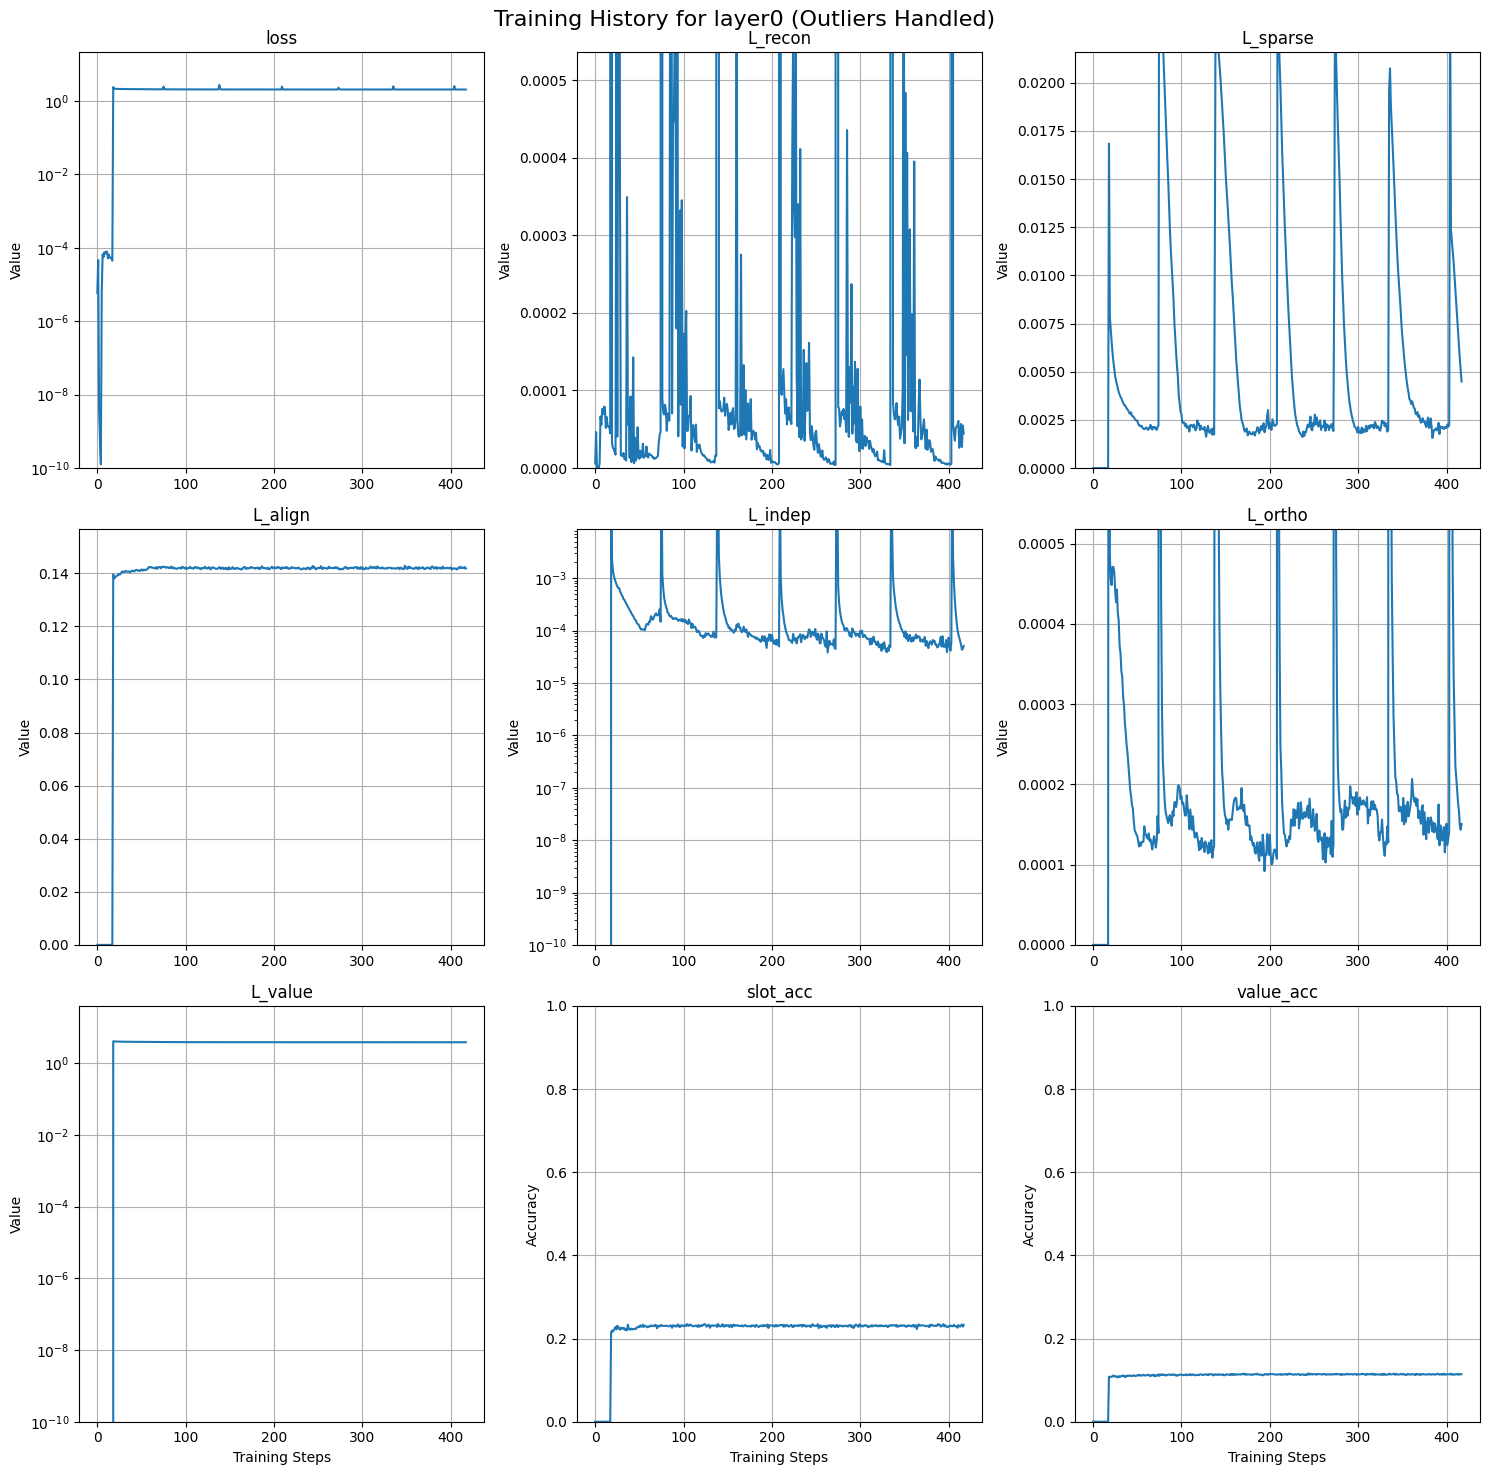

Plot for layer0 displayed.


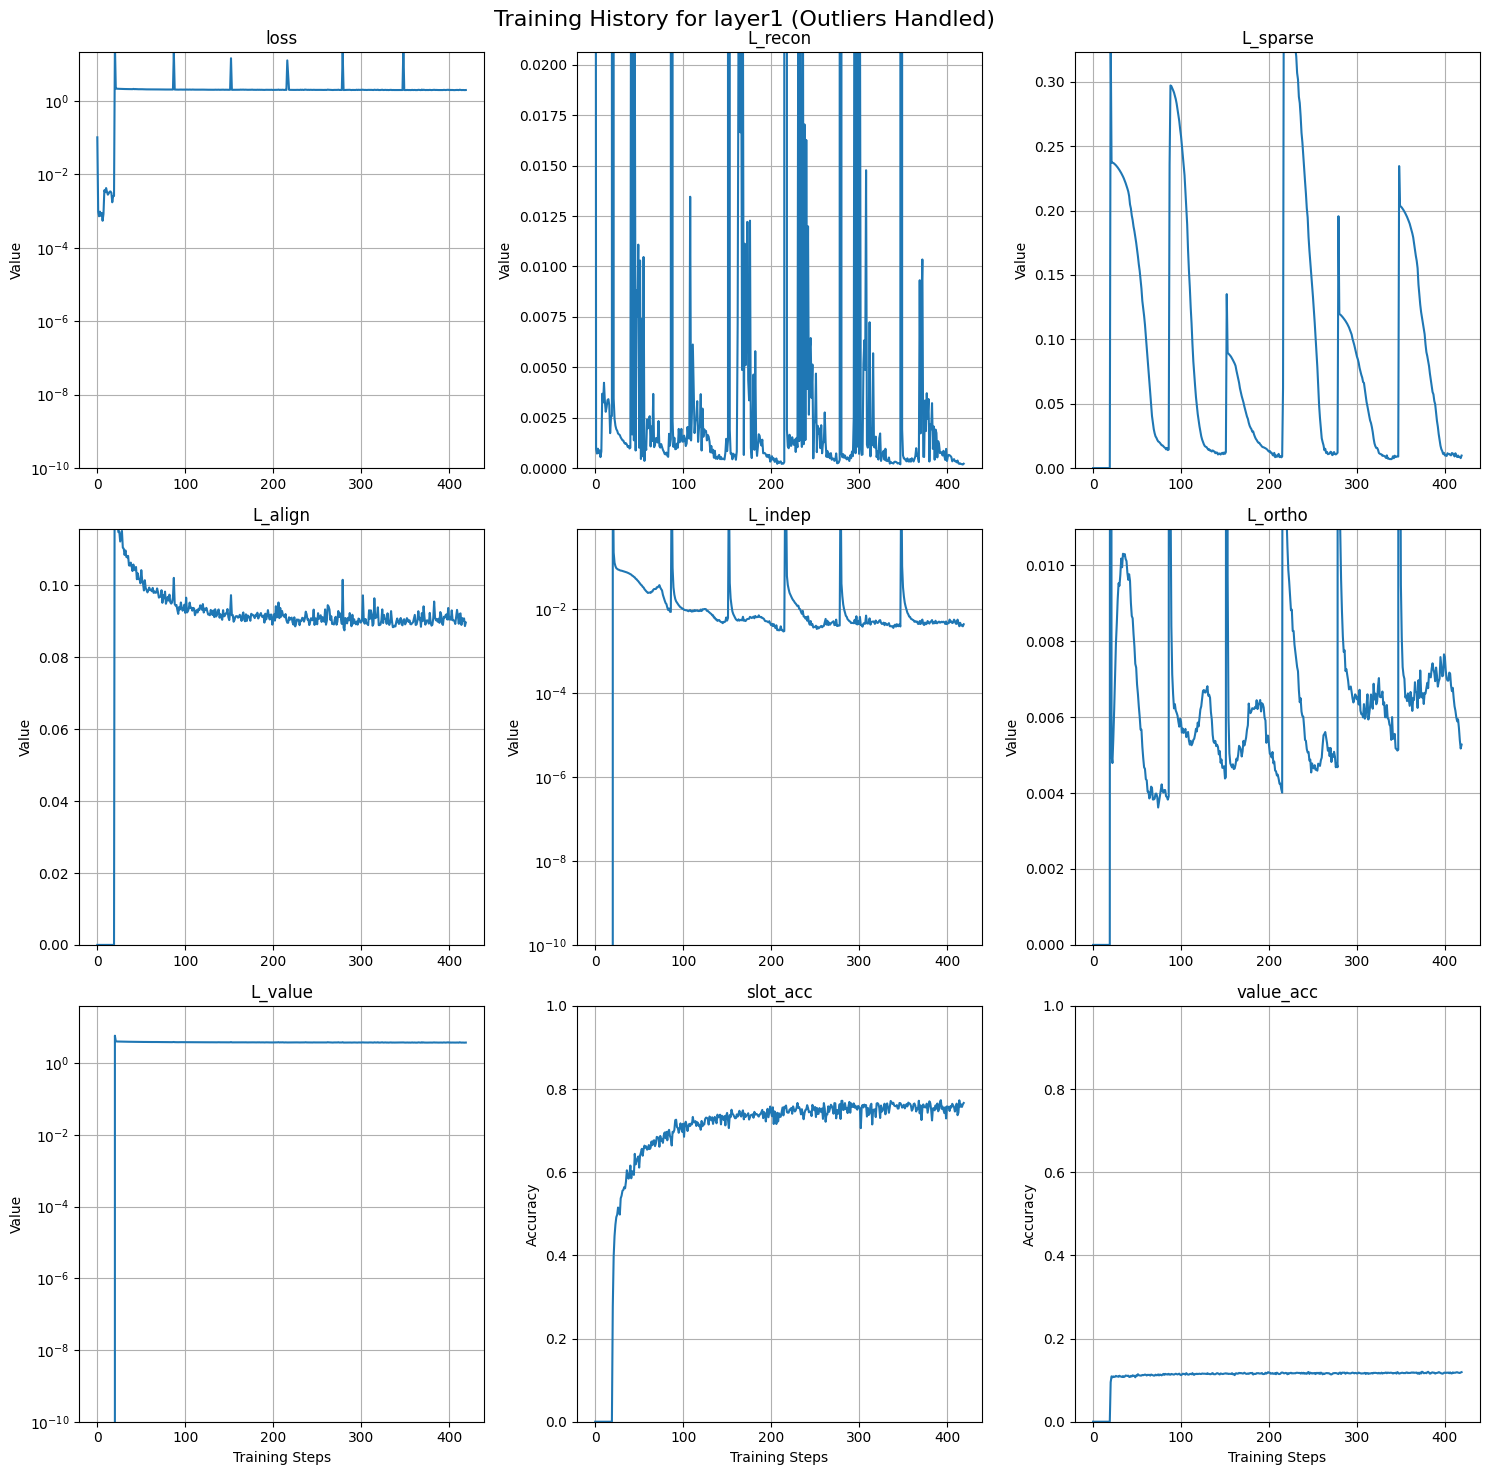

Plot for layer1 displayed.


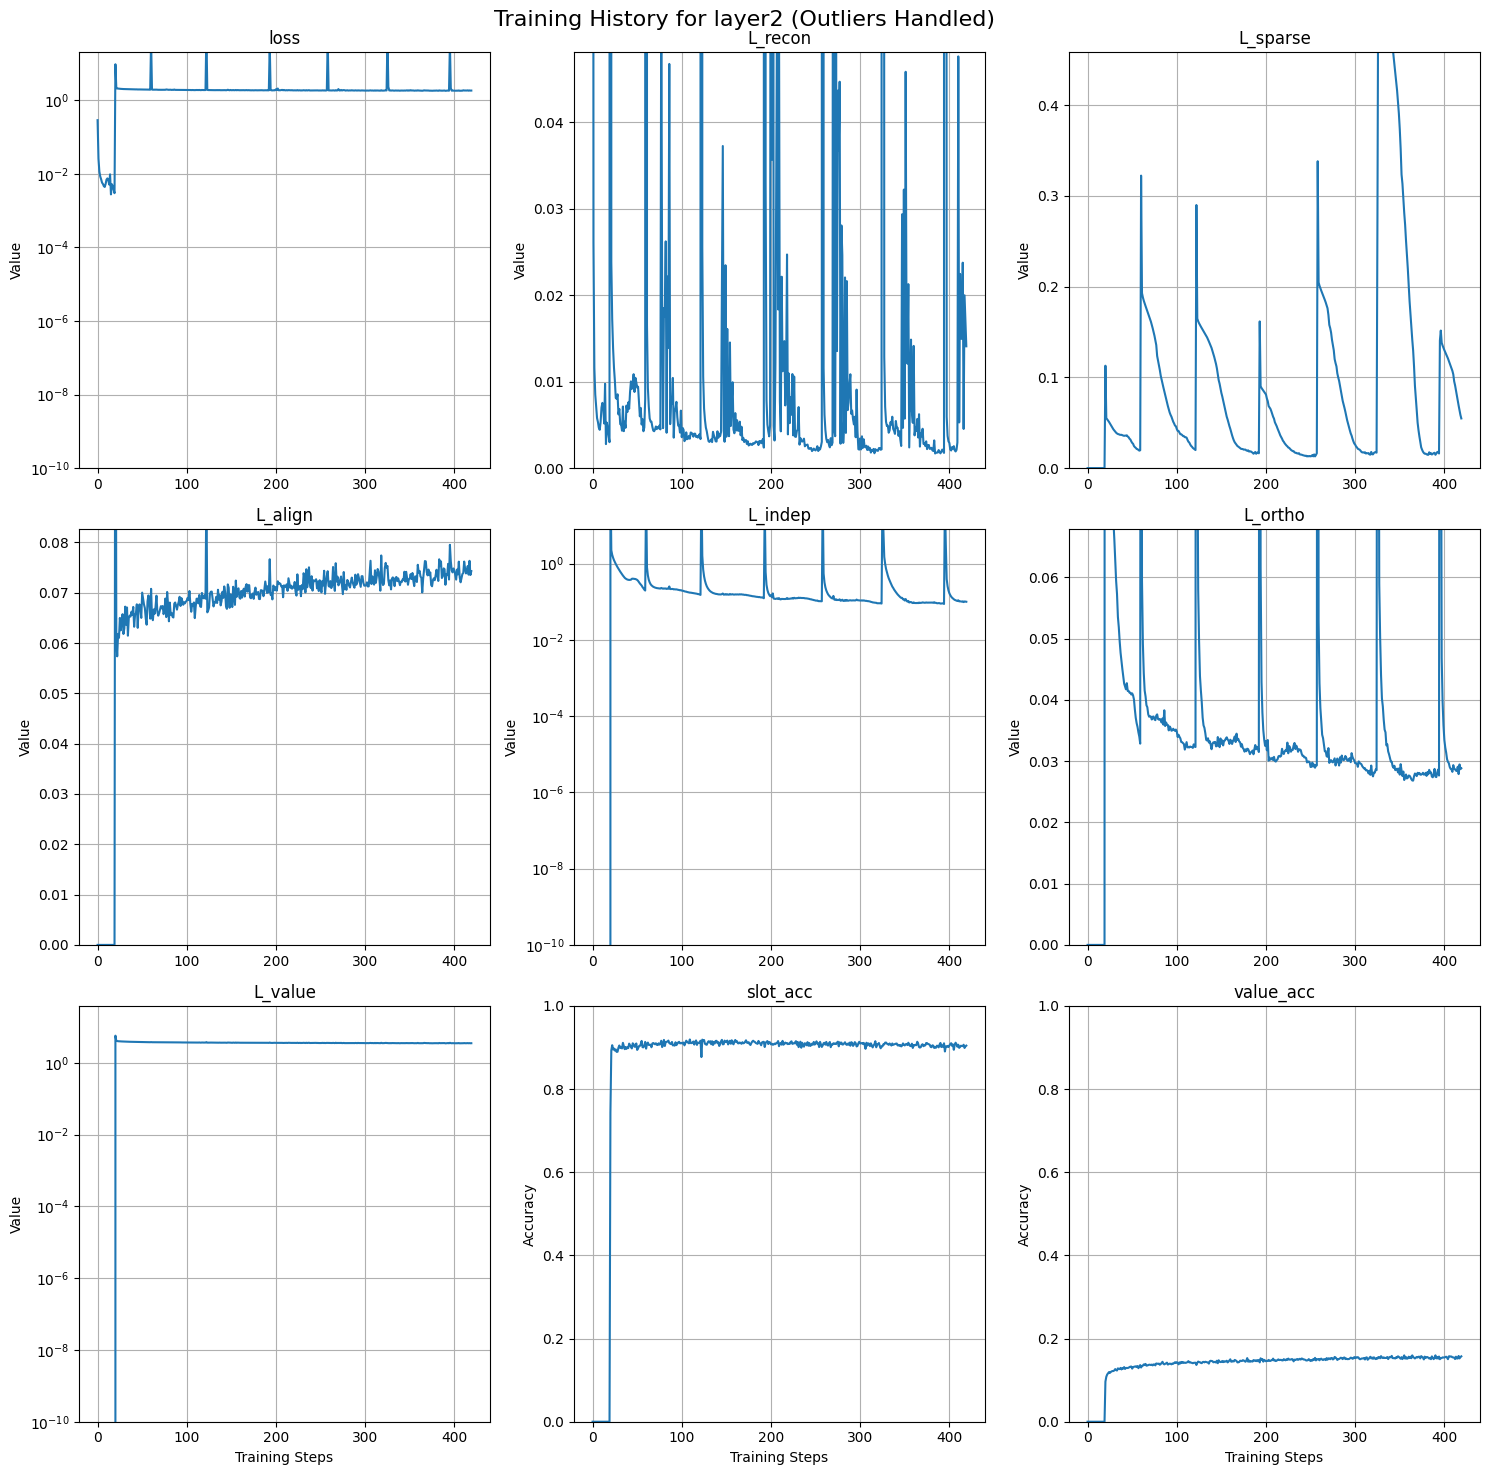

Plot for layer2 displayed.


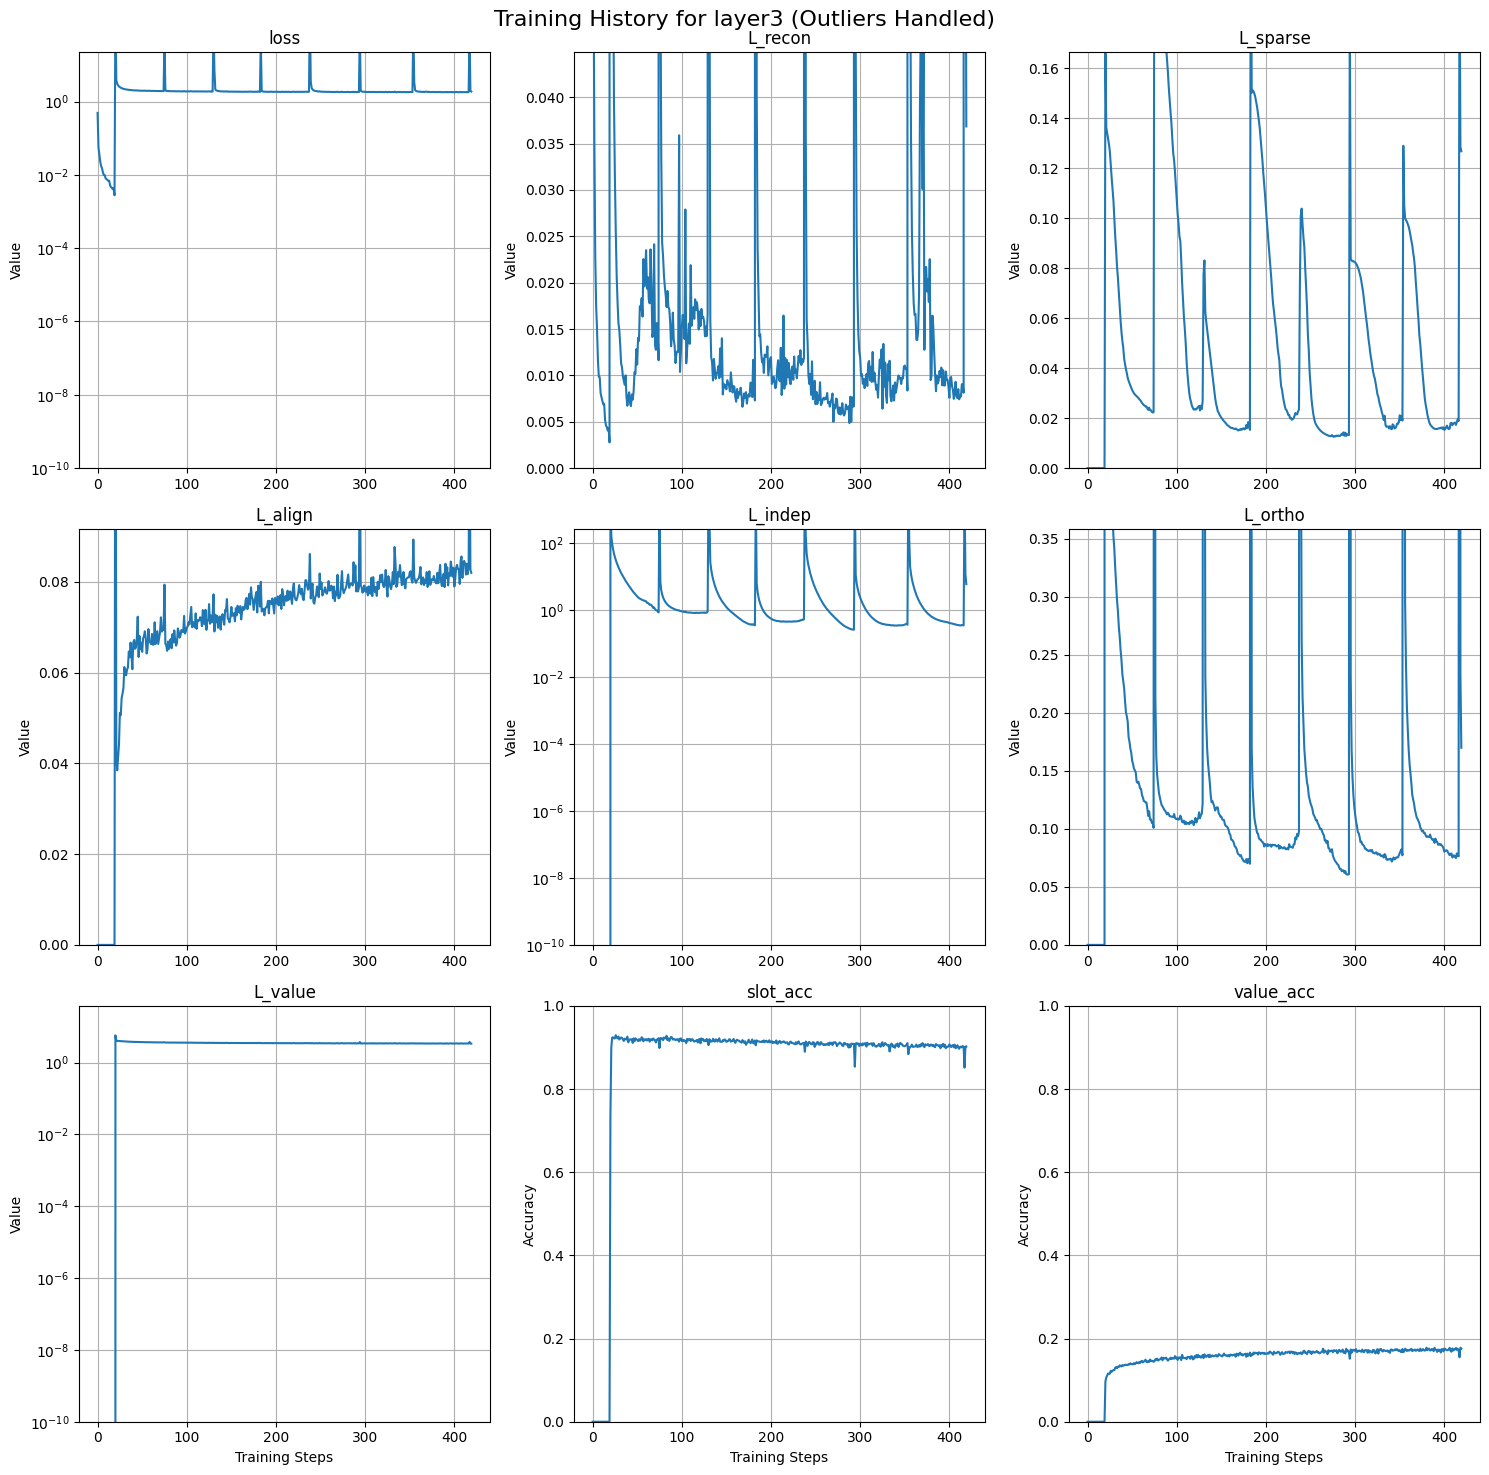

Plot for layer3 displayed.


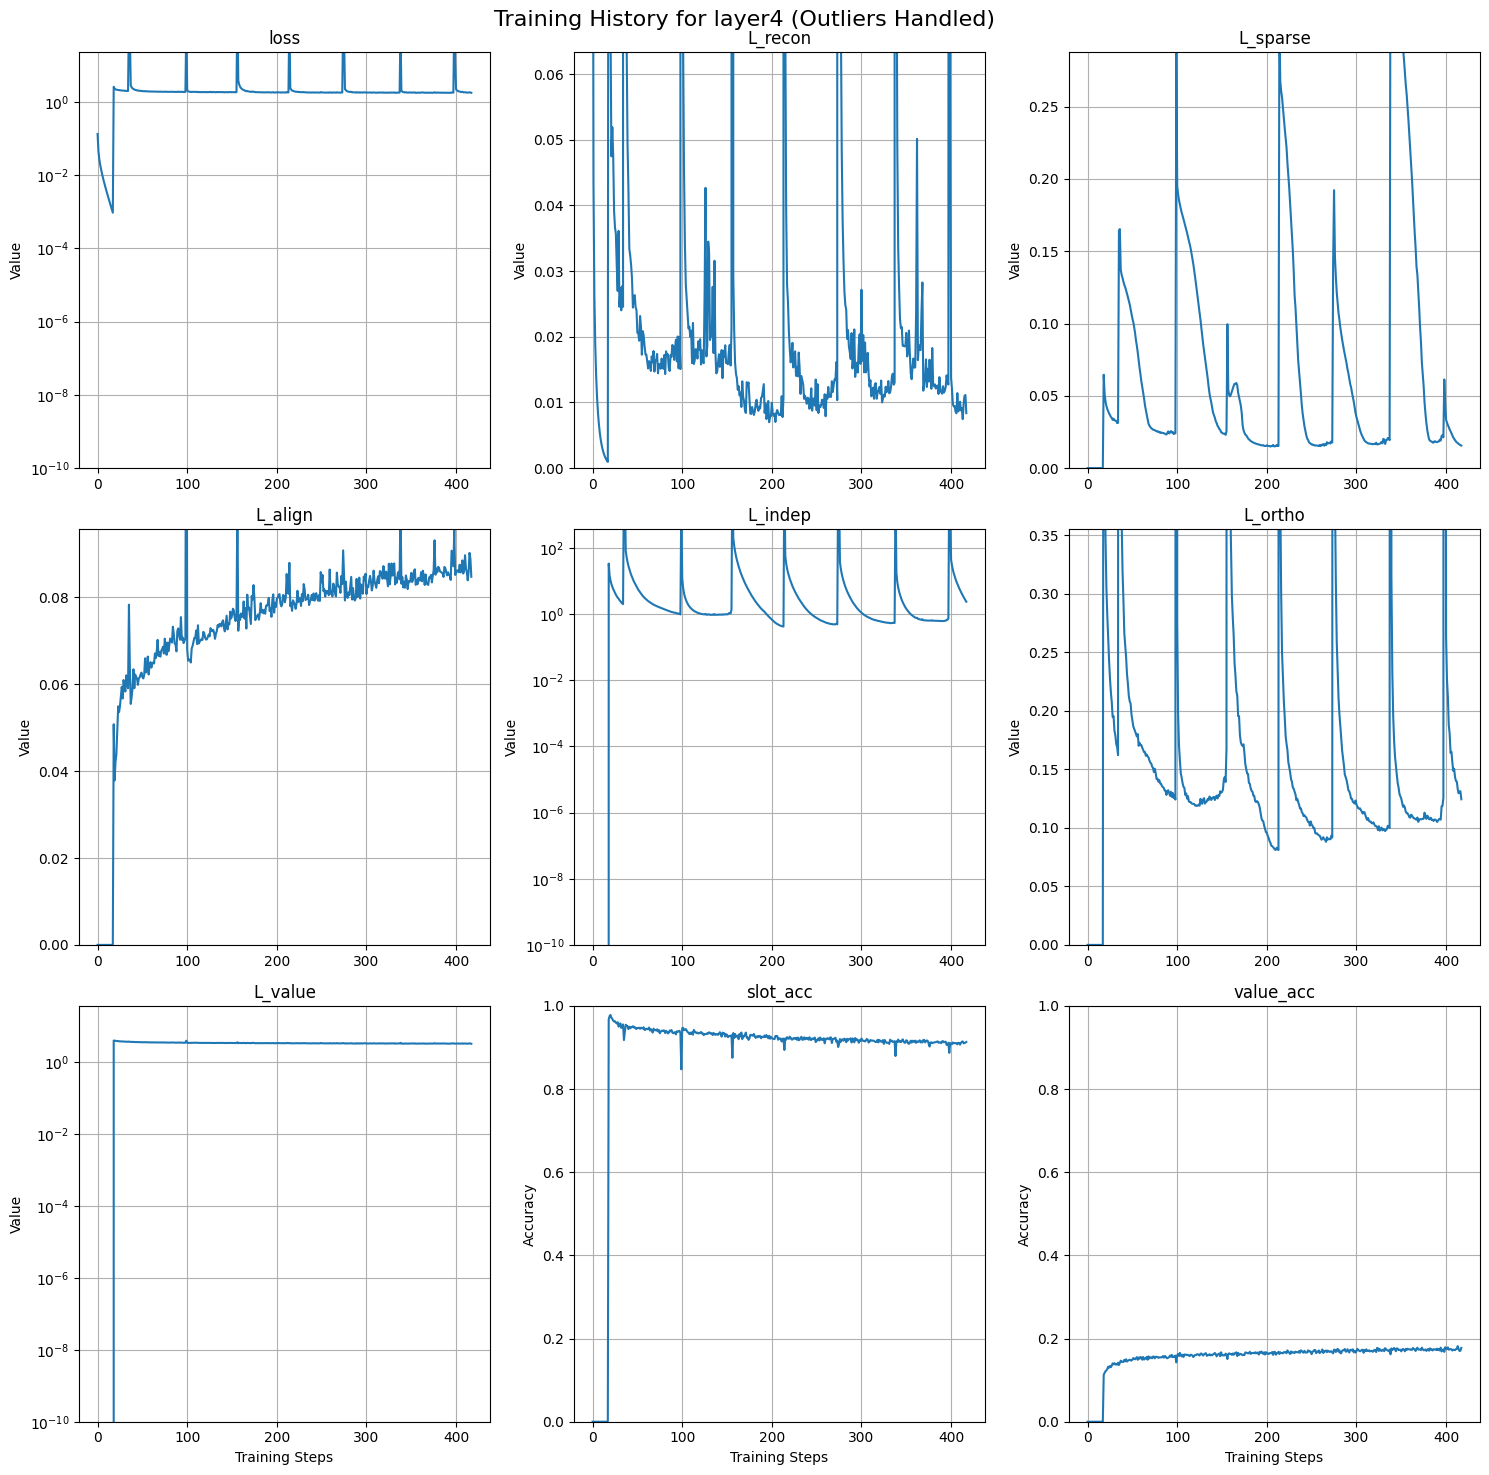

Plot for layer4 displayed.


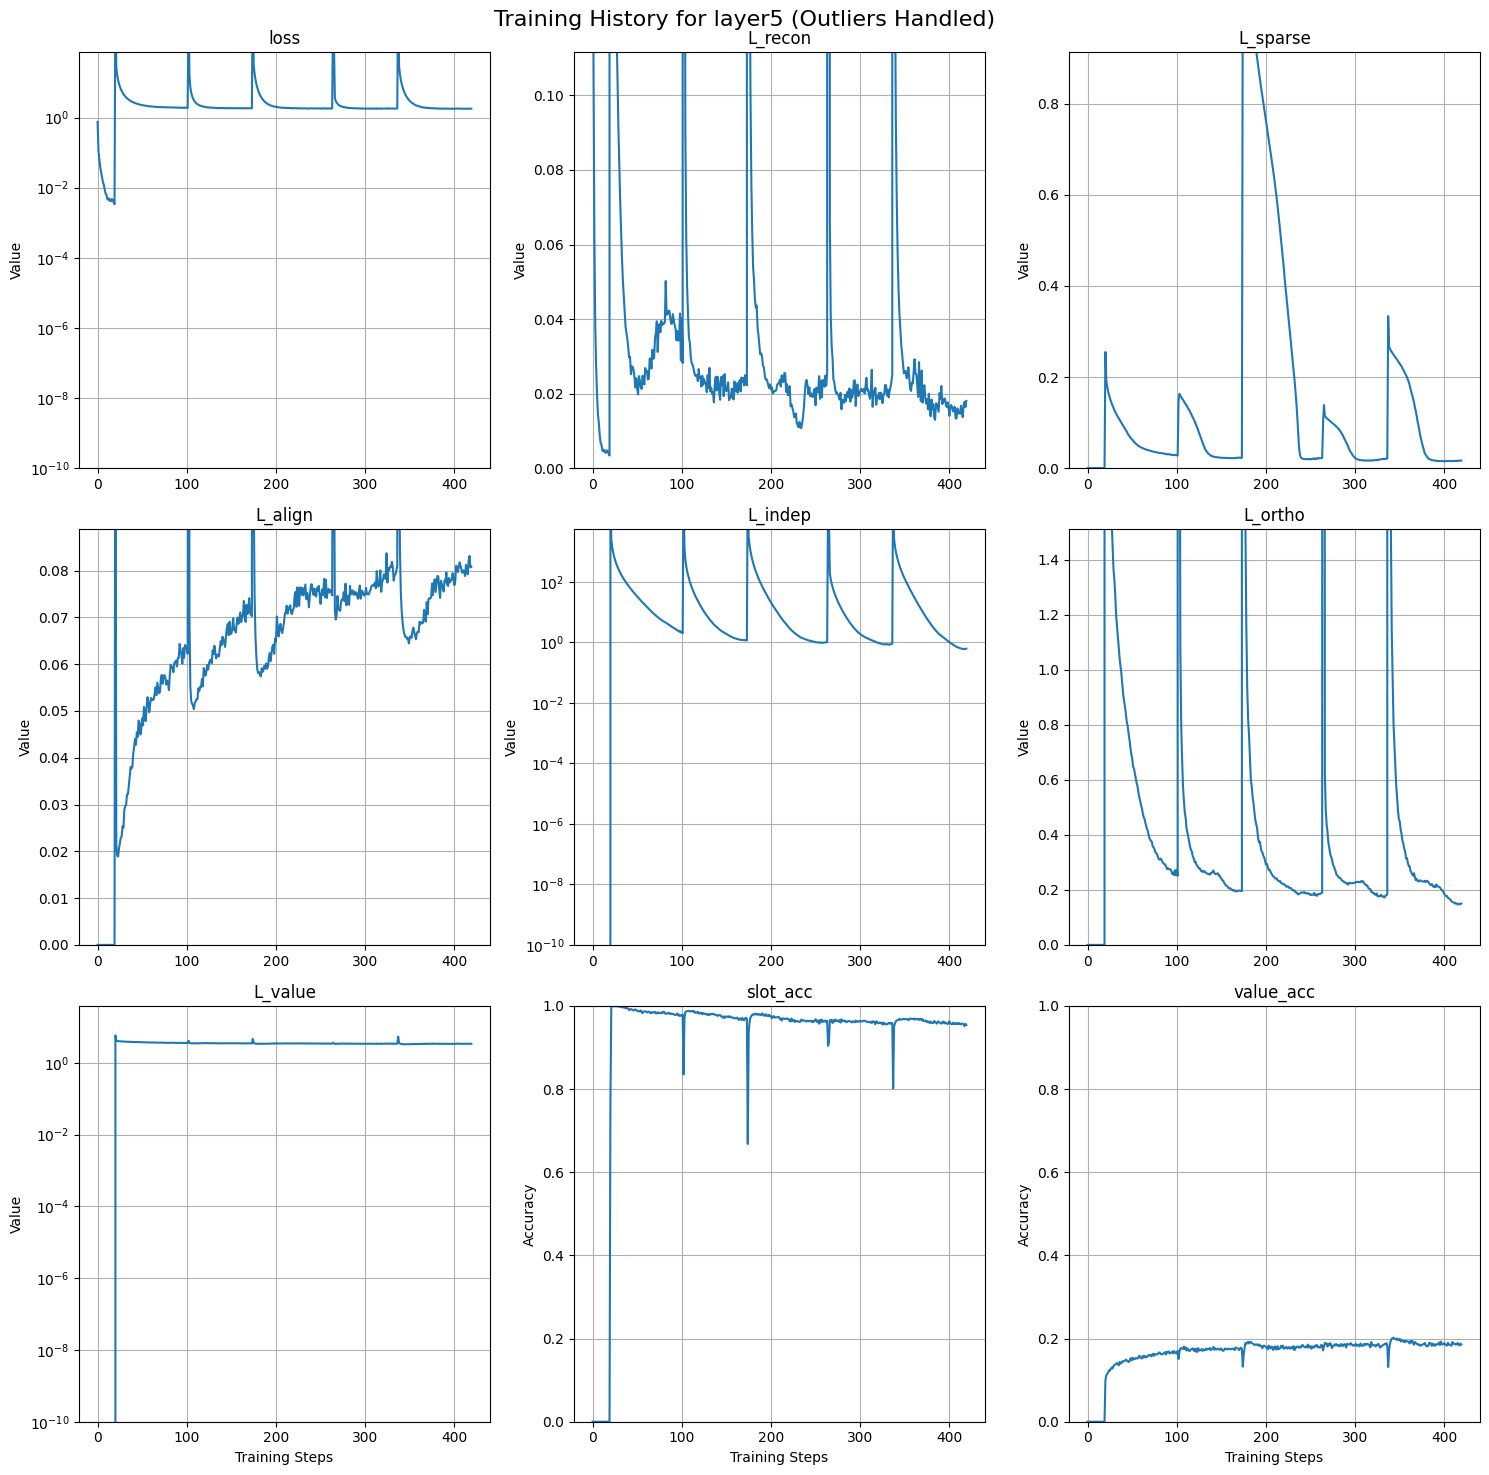

Plot for layer5 displayed.


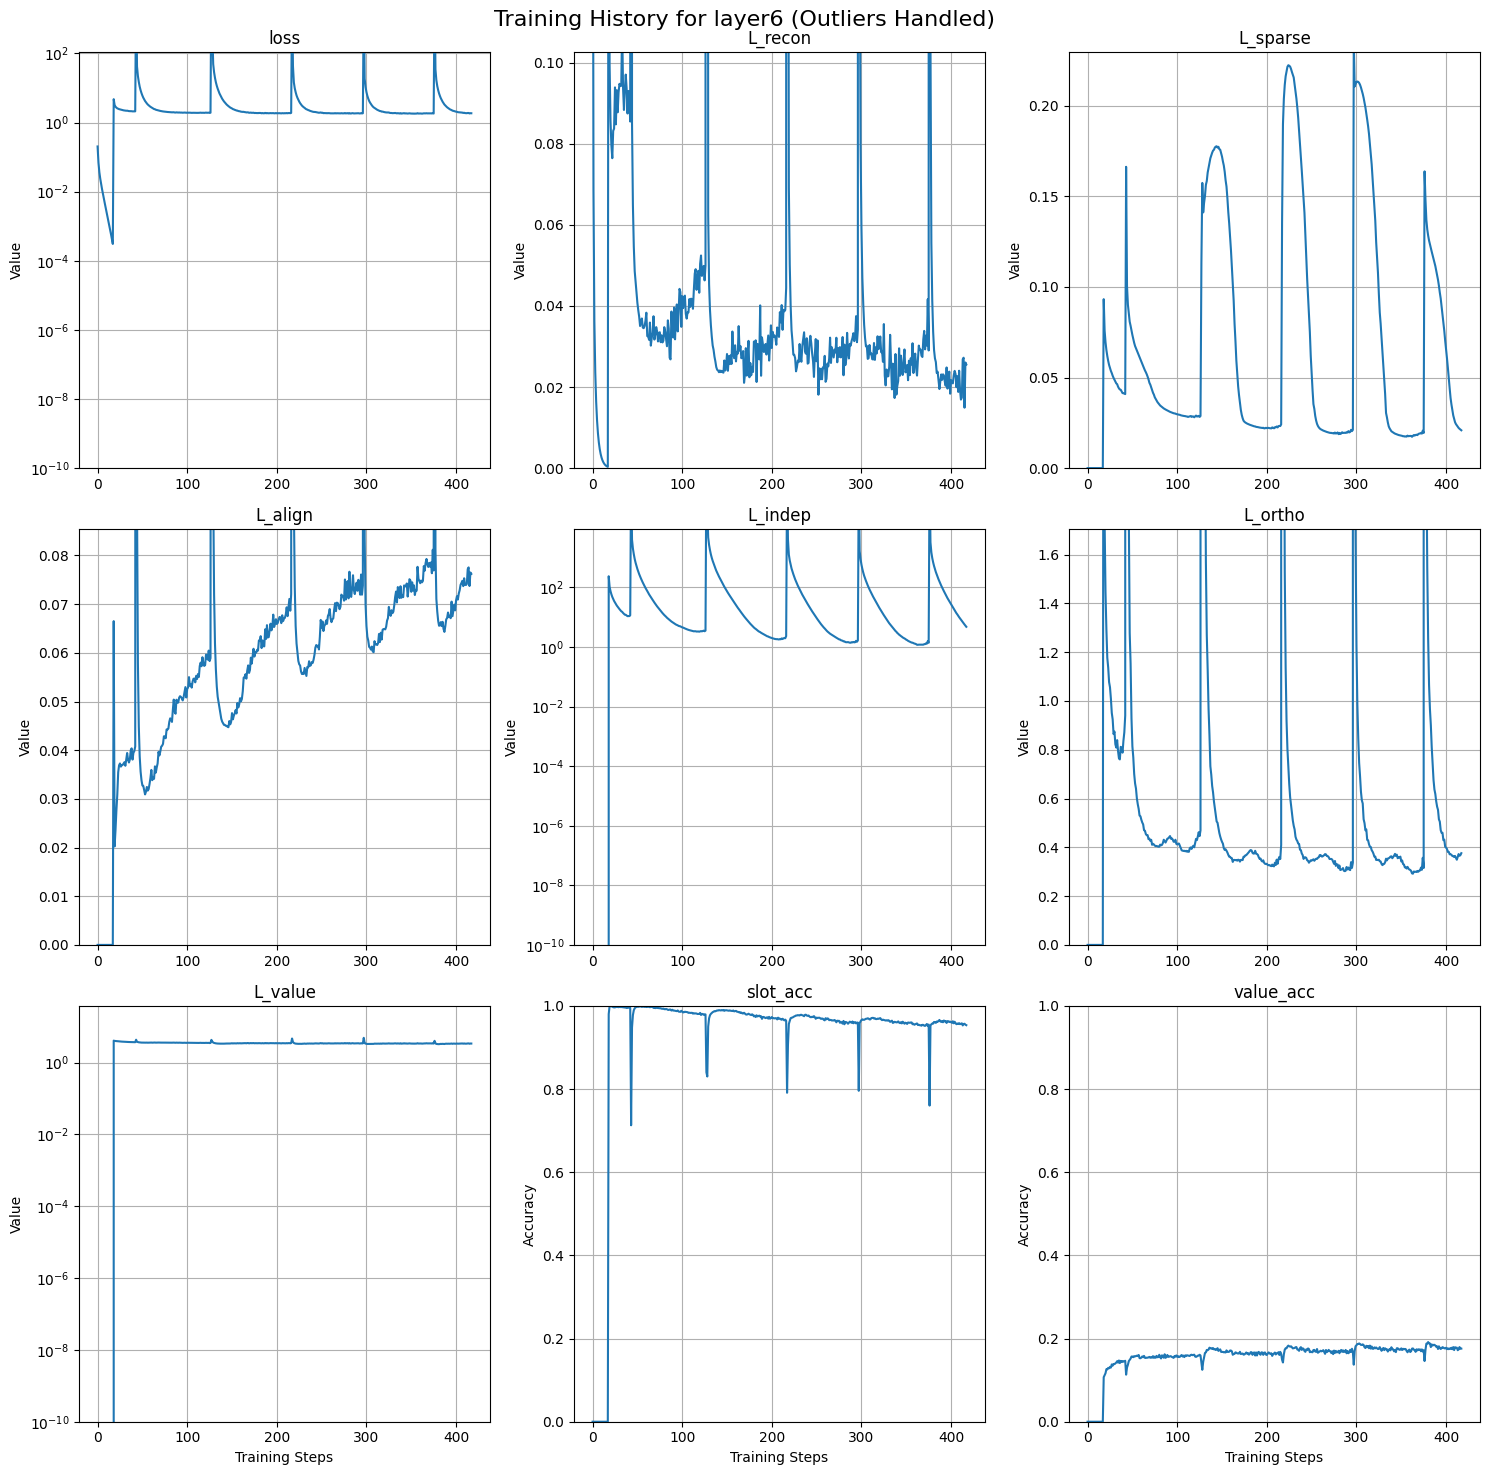

Plot for layer6 displayed.


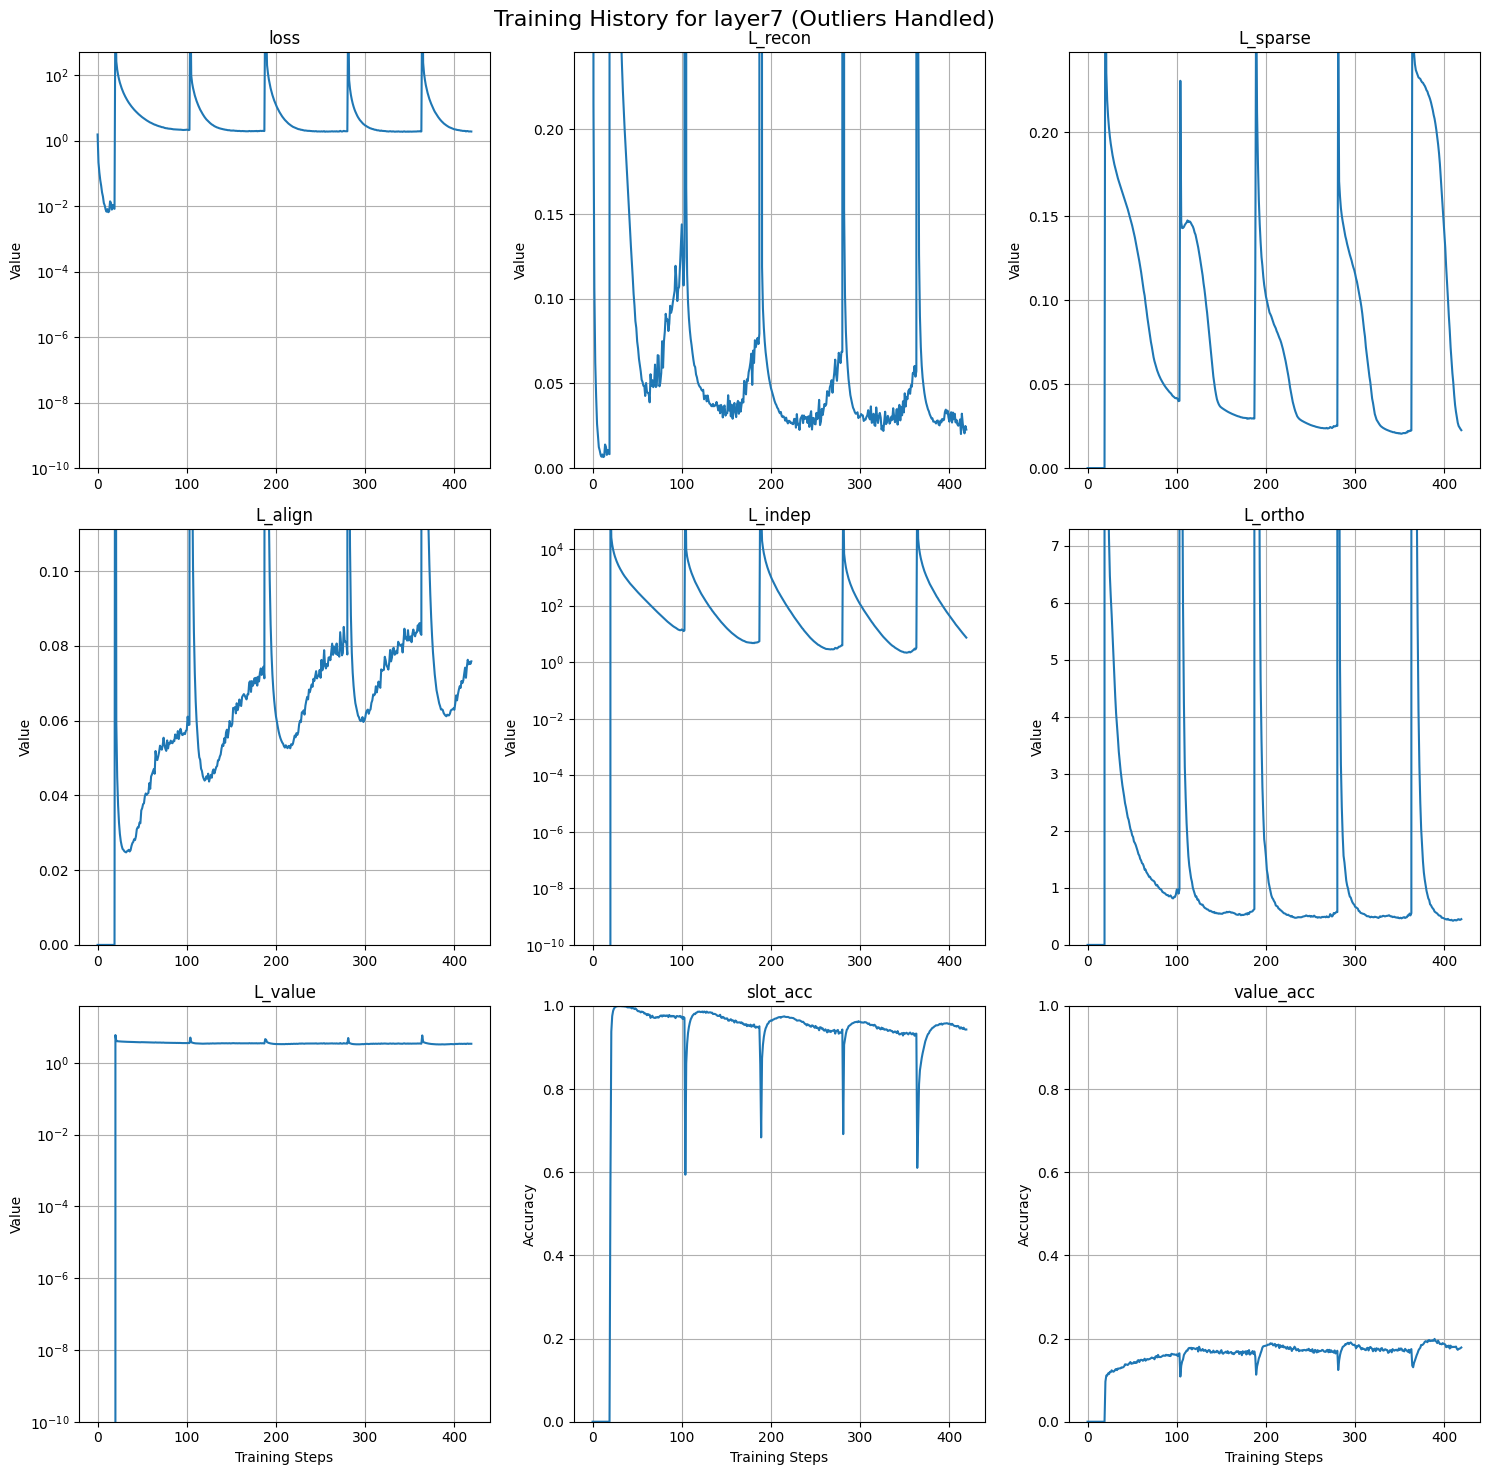

Plot for layer7 displayed.


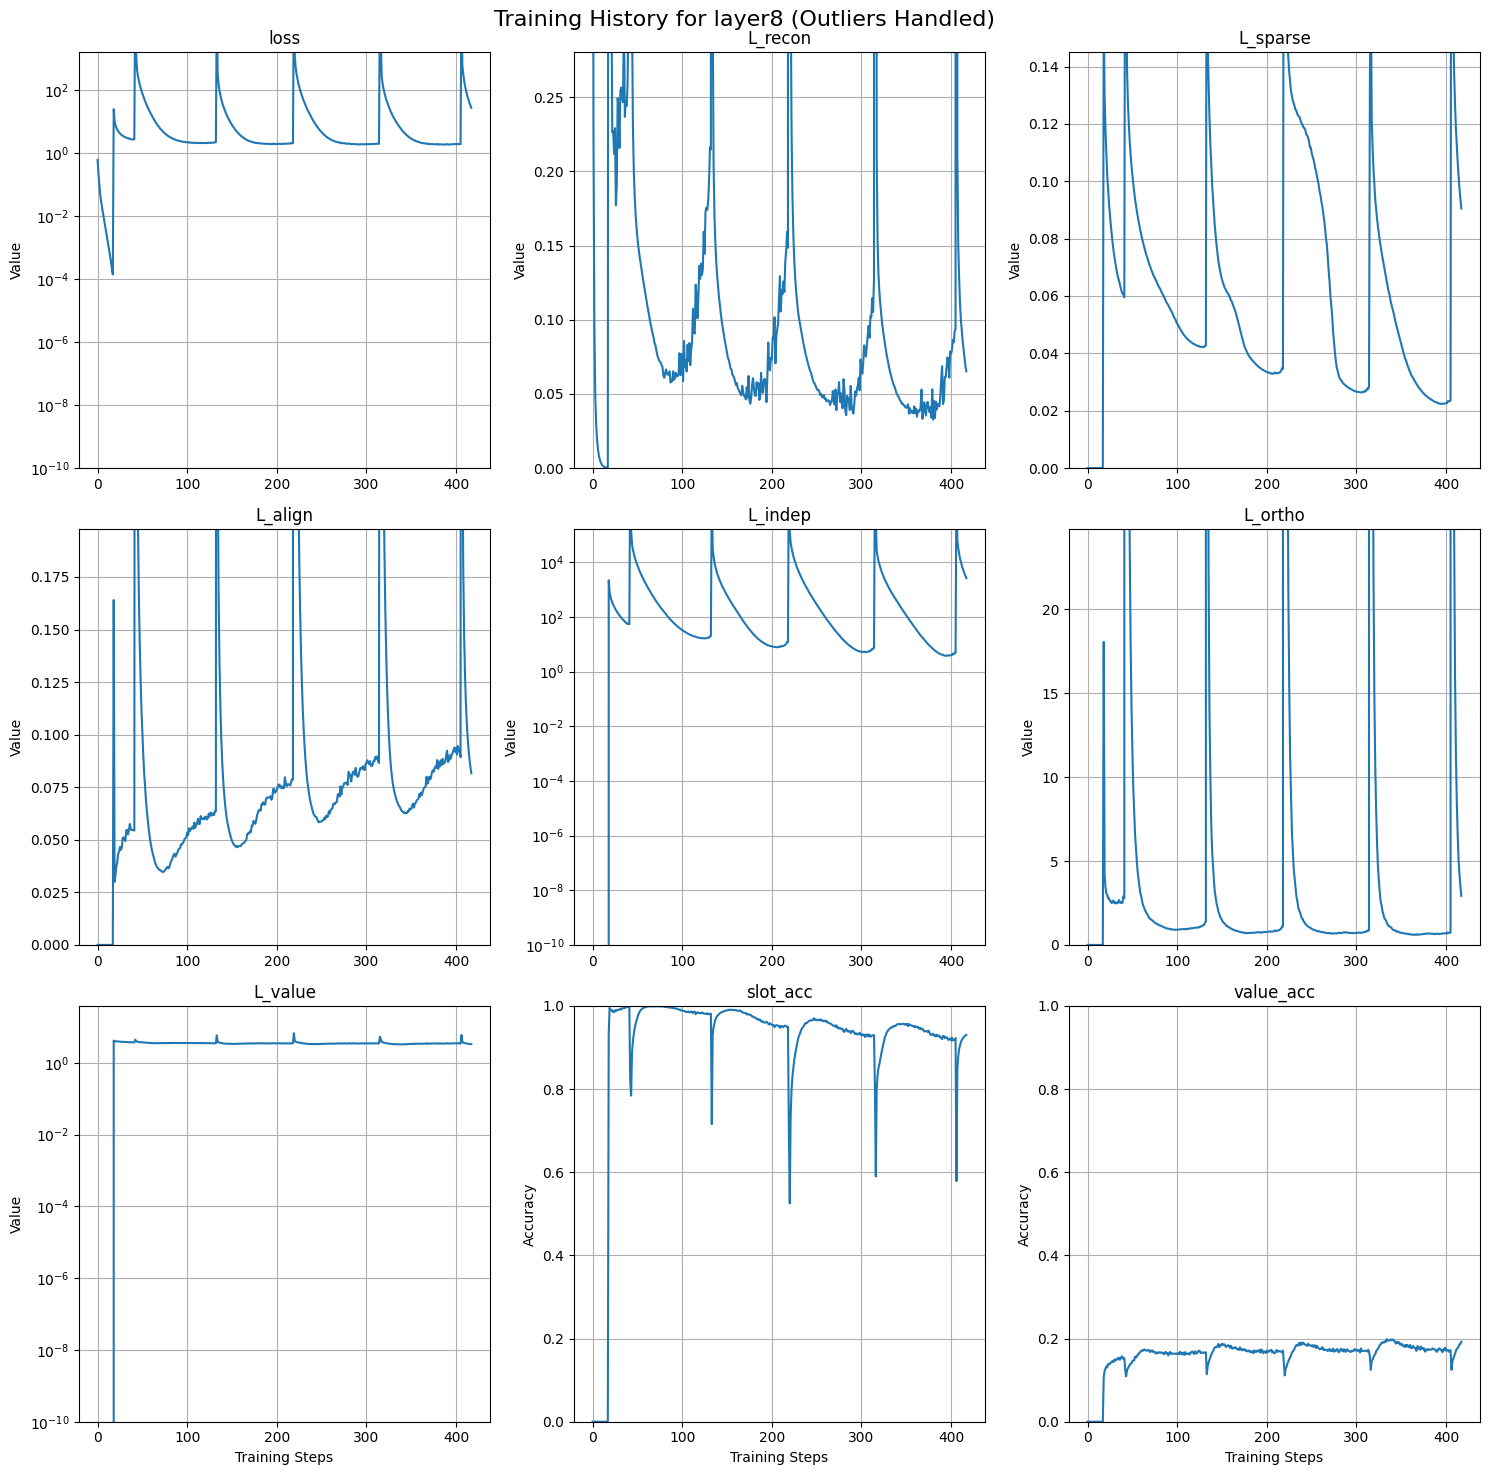

Plot for layer8 displayed.


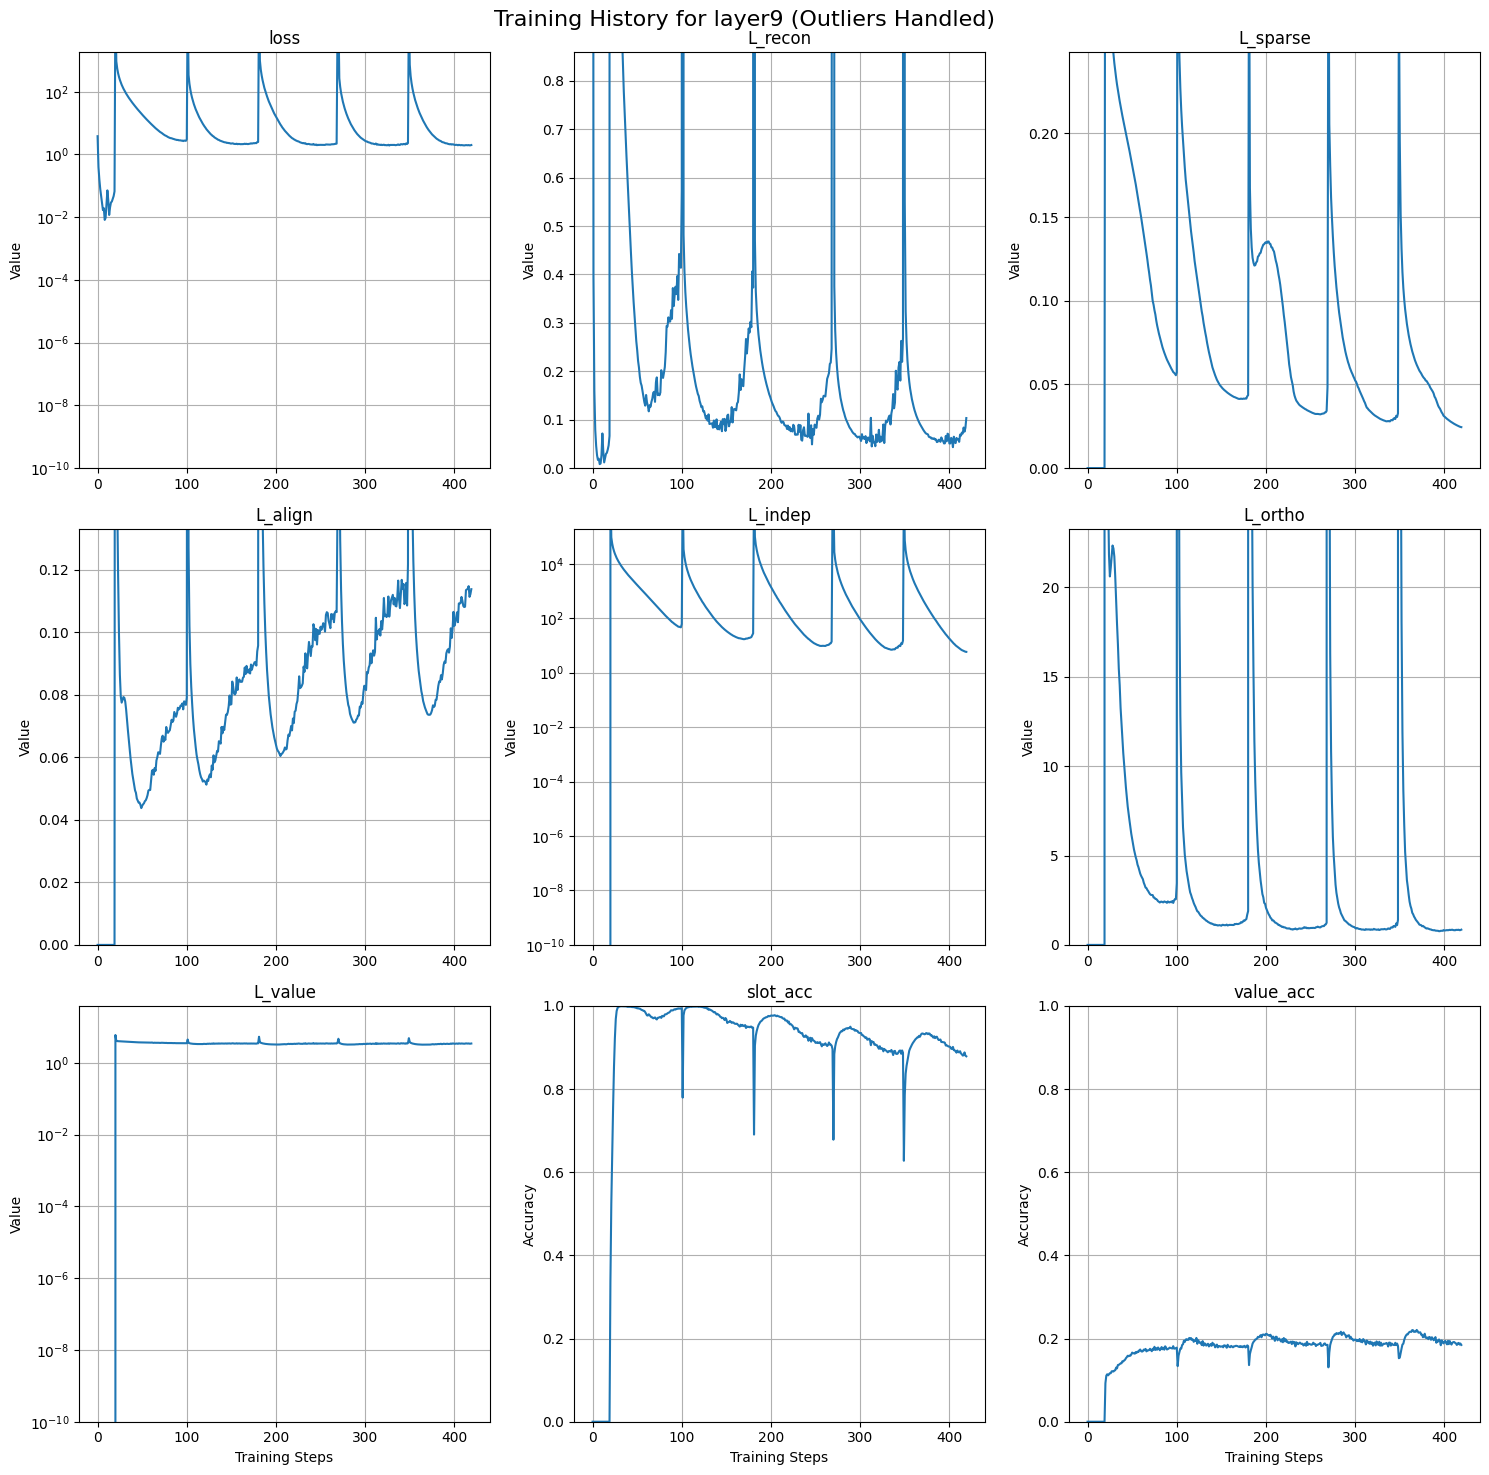

Plot for layer9 displayed.


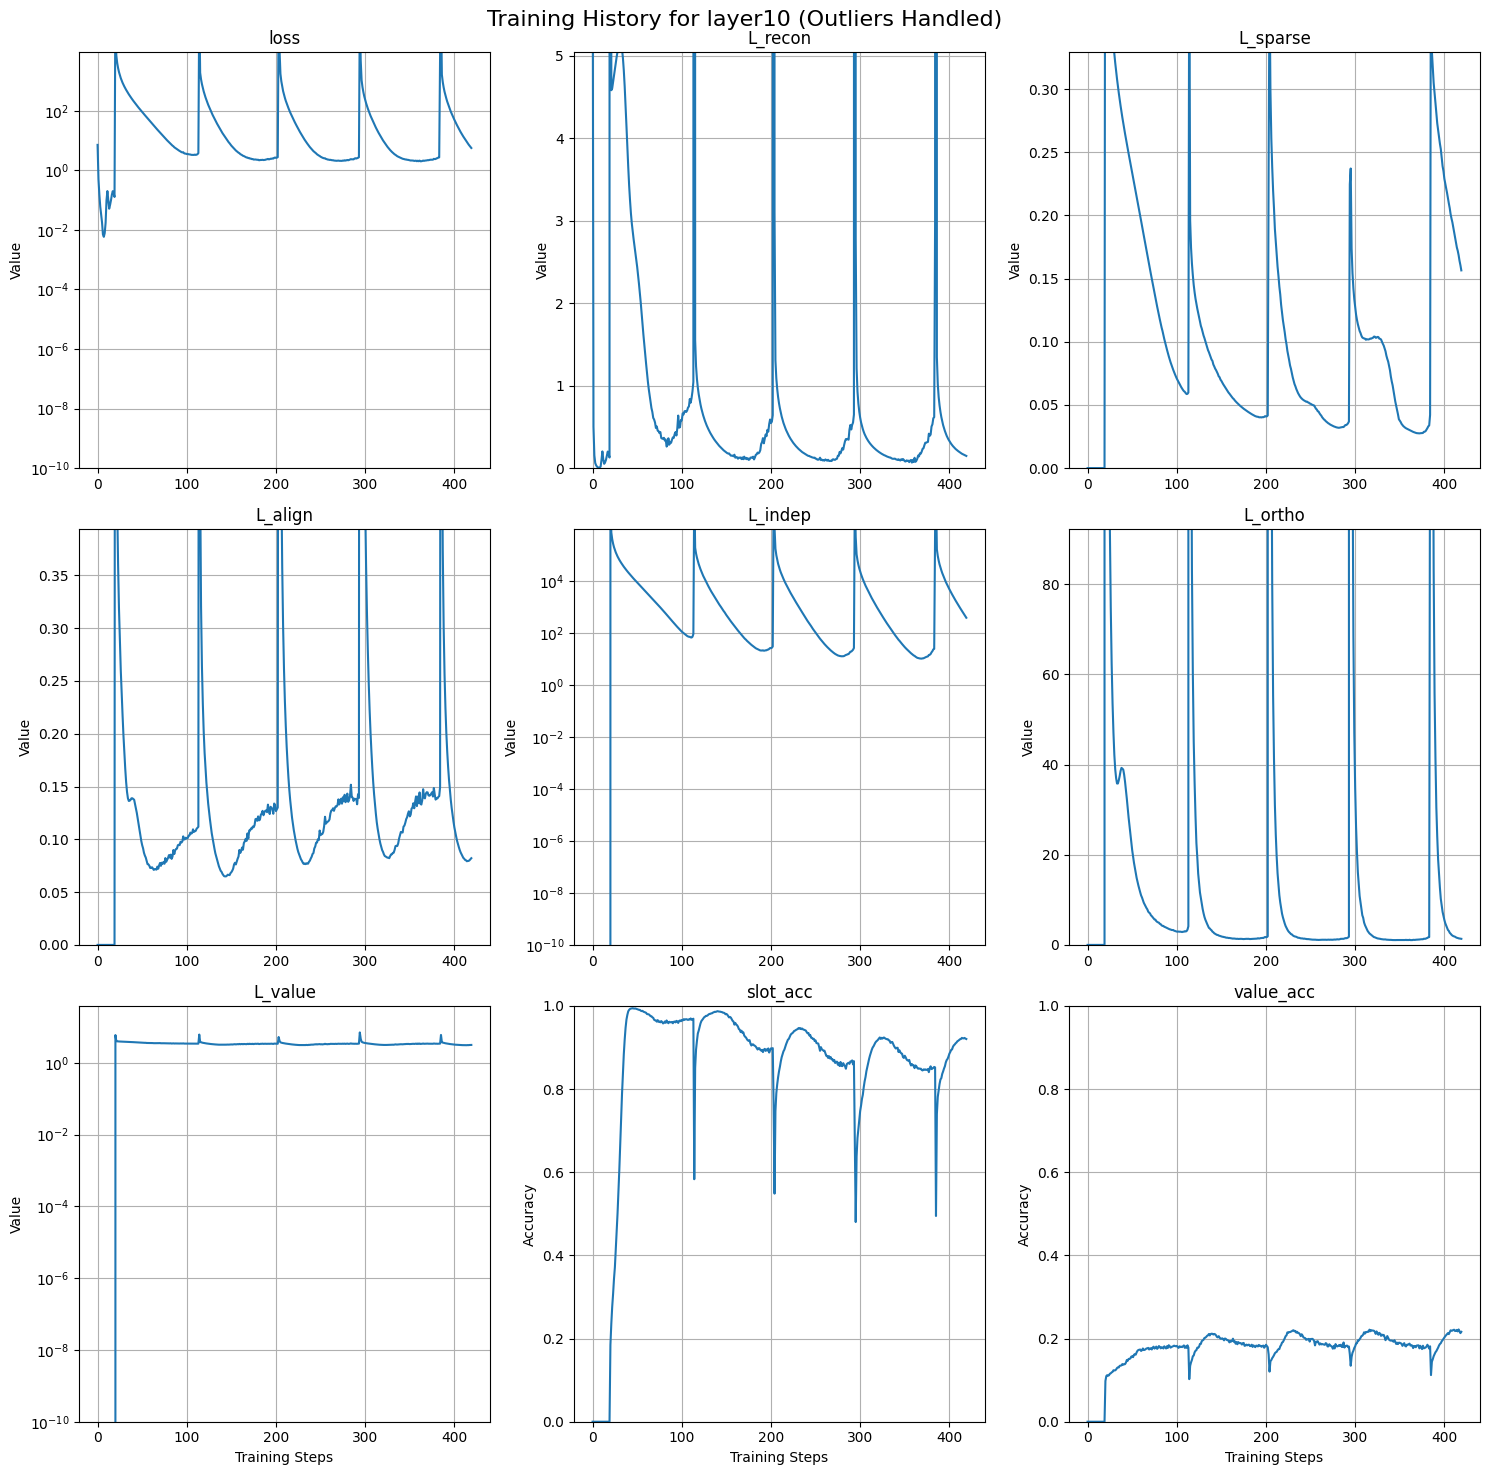

Plot for layer10 displayed.


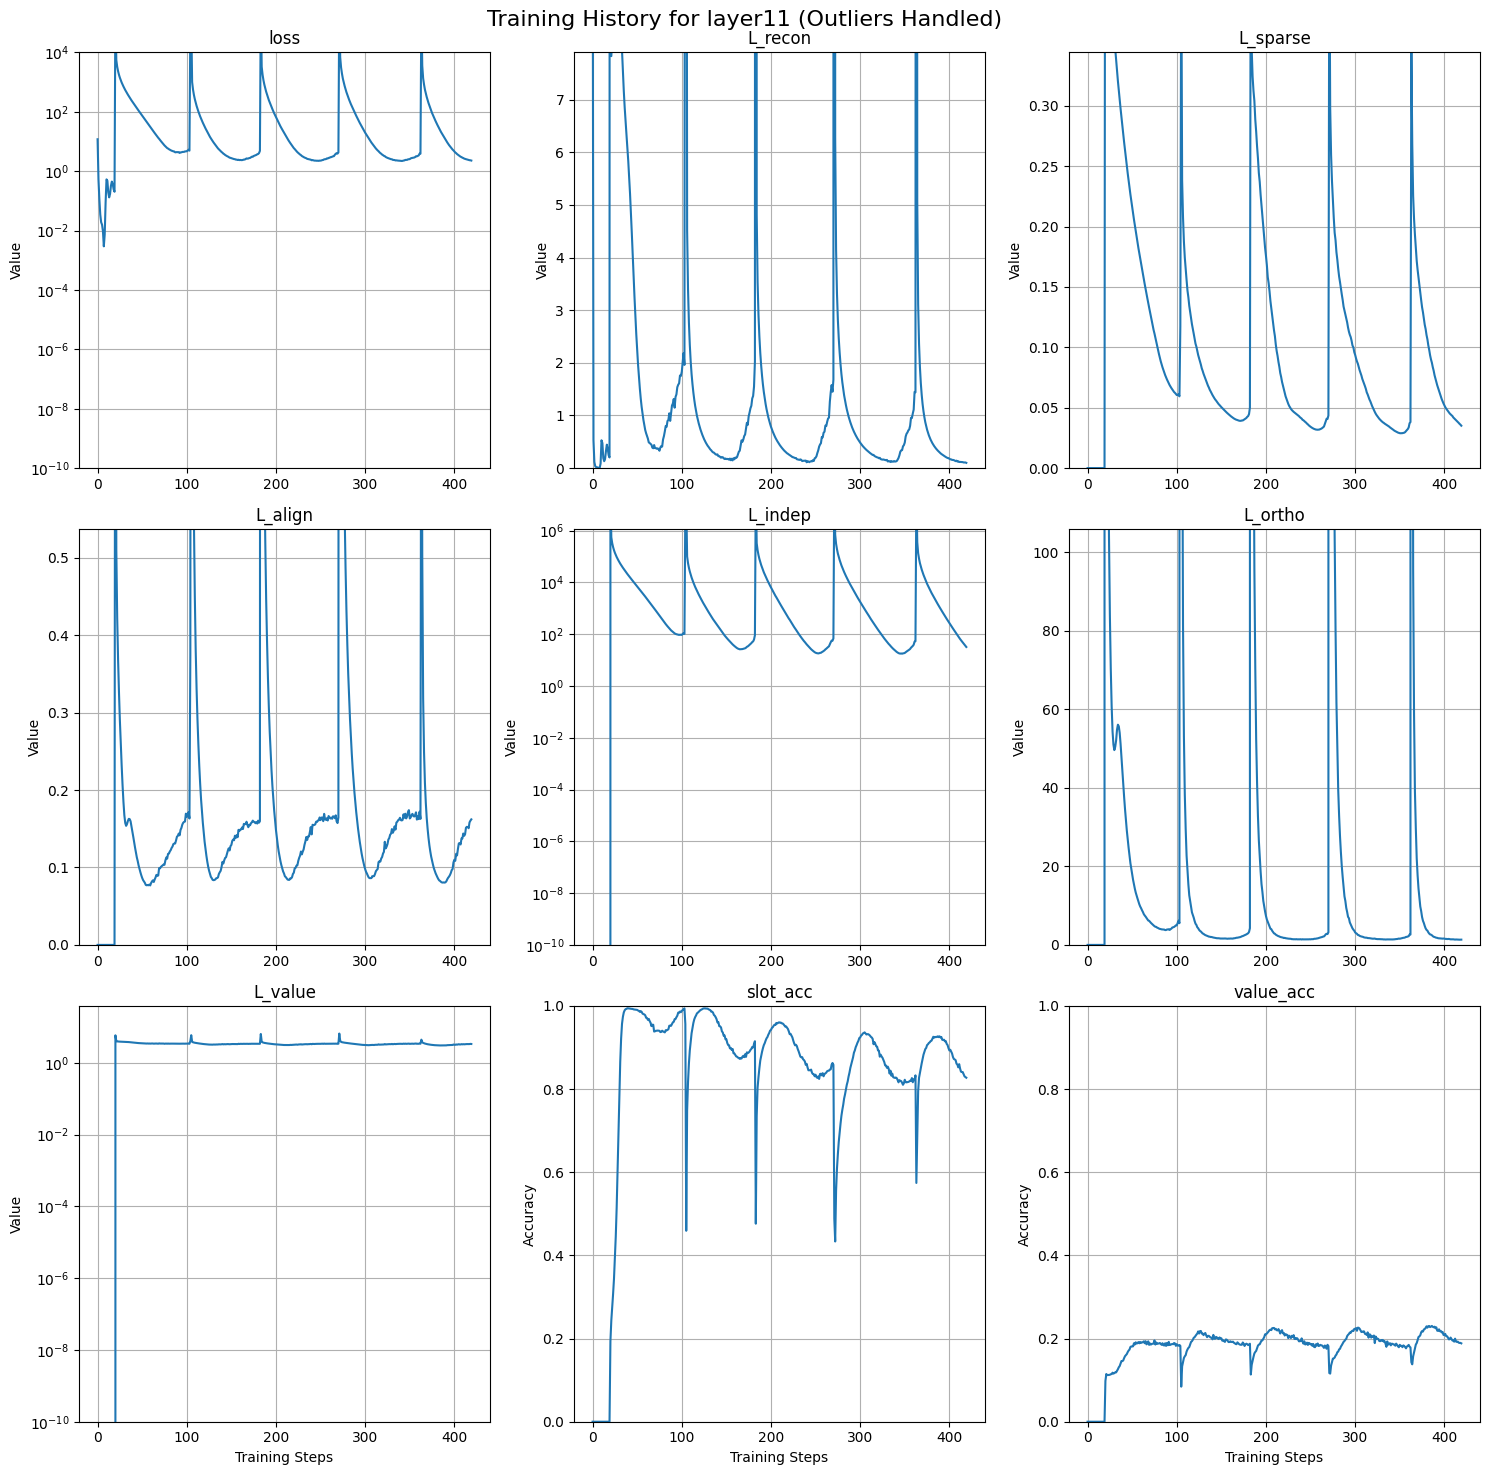

Plot for layer11 displayed.


In [2]:
# Plot for each layer
for layer in layers:
    data = load_layer_data(layer)
    
    # Extract metrics
    steps = list(range(len(data)))
    metrics = {
        'loss': [entry['loss'] for entry in data],
        'L_recon': [entry['L_recon'] for entry in data],
        'L_sparse': [entry['L_sparse'] for entry in data],
        'L_align': [entry['L_align'] for entry in data],
        'L_indep': [entry['L_indep'] for entry in data],
        'L_ortho': [entry['L_ortho'] for entry in data],
        'L_value': [entry['L_value'] for entry in data],
        'slot_acc': [entry['slot_acc'] for entry in data],
        'value_acc': [entry['value_acc'] for entry in data]
    }
    
    # Create 3x3 subplot
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    fig.suptitle(f'Training History for {layer} (Outliers Handled)', fontsize=16)
    
    # Flatten axes for easy iteration
    axes = axes.flatten()
    
    for i, (metric_name, values) in enumerate(metrics.items()):
        ax = axes[i]
        ax.plot(steps, values, label=metric_name)
        ax.set_title(metric_name)
        ax.grid(True)
        if i >= 6:  # Bottom row
            ax.set_xlabel('Training Steps')
        if metric_name in ['slot_acc', 'value_acc']:
            ax.set_ylabel('Accuracy')
            ax.set_ylim(0, 1)
        else:
            ax.set_ylabel('Value')
            # Handle outliers
            if metric_name in ['L_indep', 'L_value', 'loss']:
                ax.set_yscale('log')
                # Clip to 95th percentile
                import numpy as np
                percentile_95 = np.percentile([v for v in values if v > 0], 95)
                ax.set_ylim(bottom=1e-10, top=percentile_95 * 10)
            else:
                percentile_95 = np.percentile(values, 95)
                ax.set_ylim(0, percentile_95 * 1.1)
    
    plt.tight_layout()
    plt.show()  # Display in notebook
    
    print(f"Plot for {layer} displayed.")

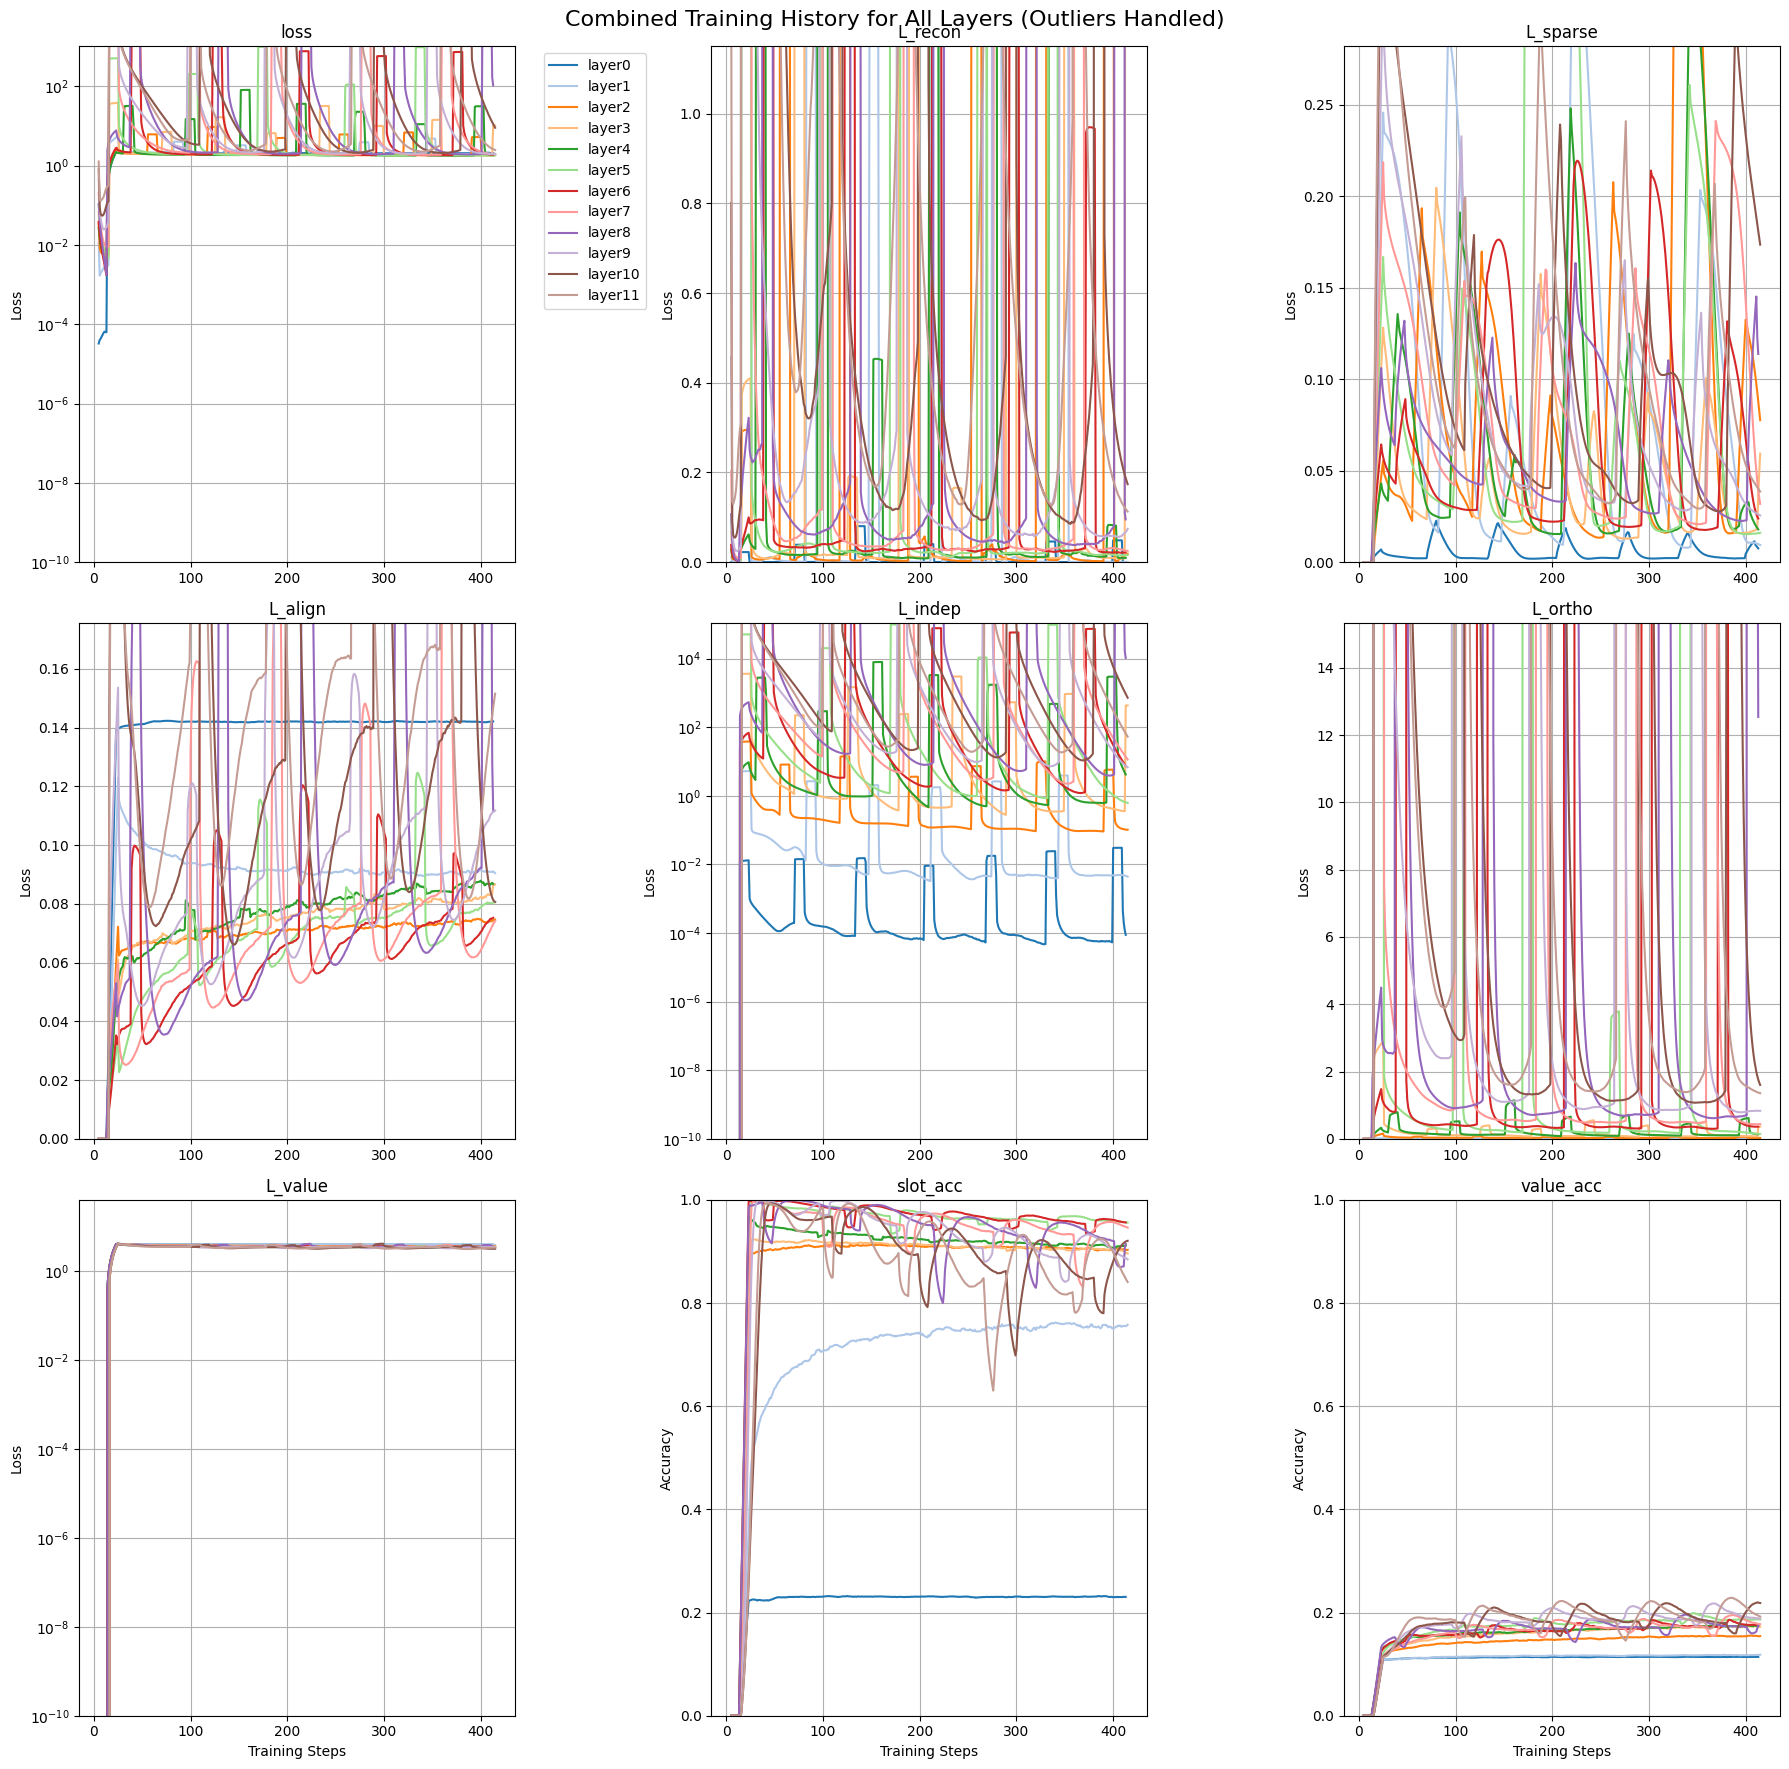

Combined plot with outlier handling displayed and saved.


In [3]:
# Combined plot for all layers
import pandas as pd
from matplotlib import cm
import numpy as np

# Load all data
all_data = {}
for layer in layers:
    all_data[layer] = load_layer_data(layer)

# Metrics to plot
metric_names = ['loss', 'L_recon', 'L_sparse', 'L_align', 'L_indep', 'L_ortho', 'L_value', 'slot_acc', 'value_acc']

# Colormap for layers
colors = cm.tab20.colors[:len(layers)]  # Use tab20 for distinct colors

# Create 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('Combined Training History for All Layers (Outliers Handled)', fontsize=16)
axes = axes.flatten()

for i, metric in enumerate(metric_names):
    ax = axes[i]
    all_values = []
    for j, layer in enumerate(layers):
        data = all_data[layer]
        steps = list(range(len(data)))
        values = [entry[metric] for entry in data]
        all_values.extend(values)
        
        # Smooth using rolling mean
        df = pd.DataFrame({'steps': steps, 'values': values})
        smoothed = df['values'].rolling(window=10, center=True).mean()
        
        # Plot
        ax.plot(steps, smoothed, label=layer, color=colors[j], linewidth=1.5)
    
    ax.set_title(metric)
    ax.grid(True)
    if i >= 6:
        ax.set_xlabel('Training Steps')
    if metric in ['slot_acc', 'value_acc']:
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)  # Clip accuracies to 0-1
    else:
        ax.set_ylabel('Loss')
        # Handle outliers: use log scale for wide ranges, and clip to 95th percentile
        if metric in ['L_indep', 'L_value', 'loss']:
            ax.set_yscale('log')
            # Clip to 95th percentile to remove extreme outliers
            percentile_95 = np.percentile([v for v in all_values if v > 0], 95)
            ax.set_ylim(bottom=1e-10, top=percentile_95 * 10)  # Adjust as needed
        else:
            # For other losses, clip to 95th percentile
            percentile_95 = np.percentile(all_values, 95)
            ax.set_ylim(0, percentile_95 * 1.1)
    
    # Only show legend for first subplot to avoid clutter
    if i == 0:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.savefig('combined_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print("Combined plot with outlier handling displayed and saved.")

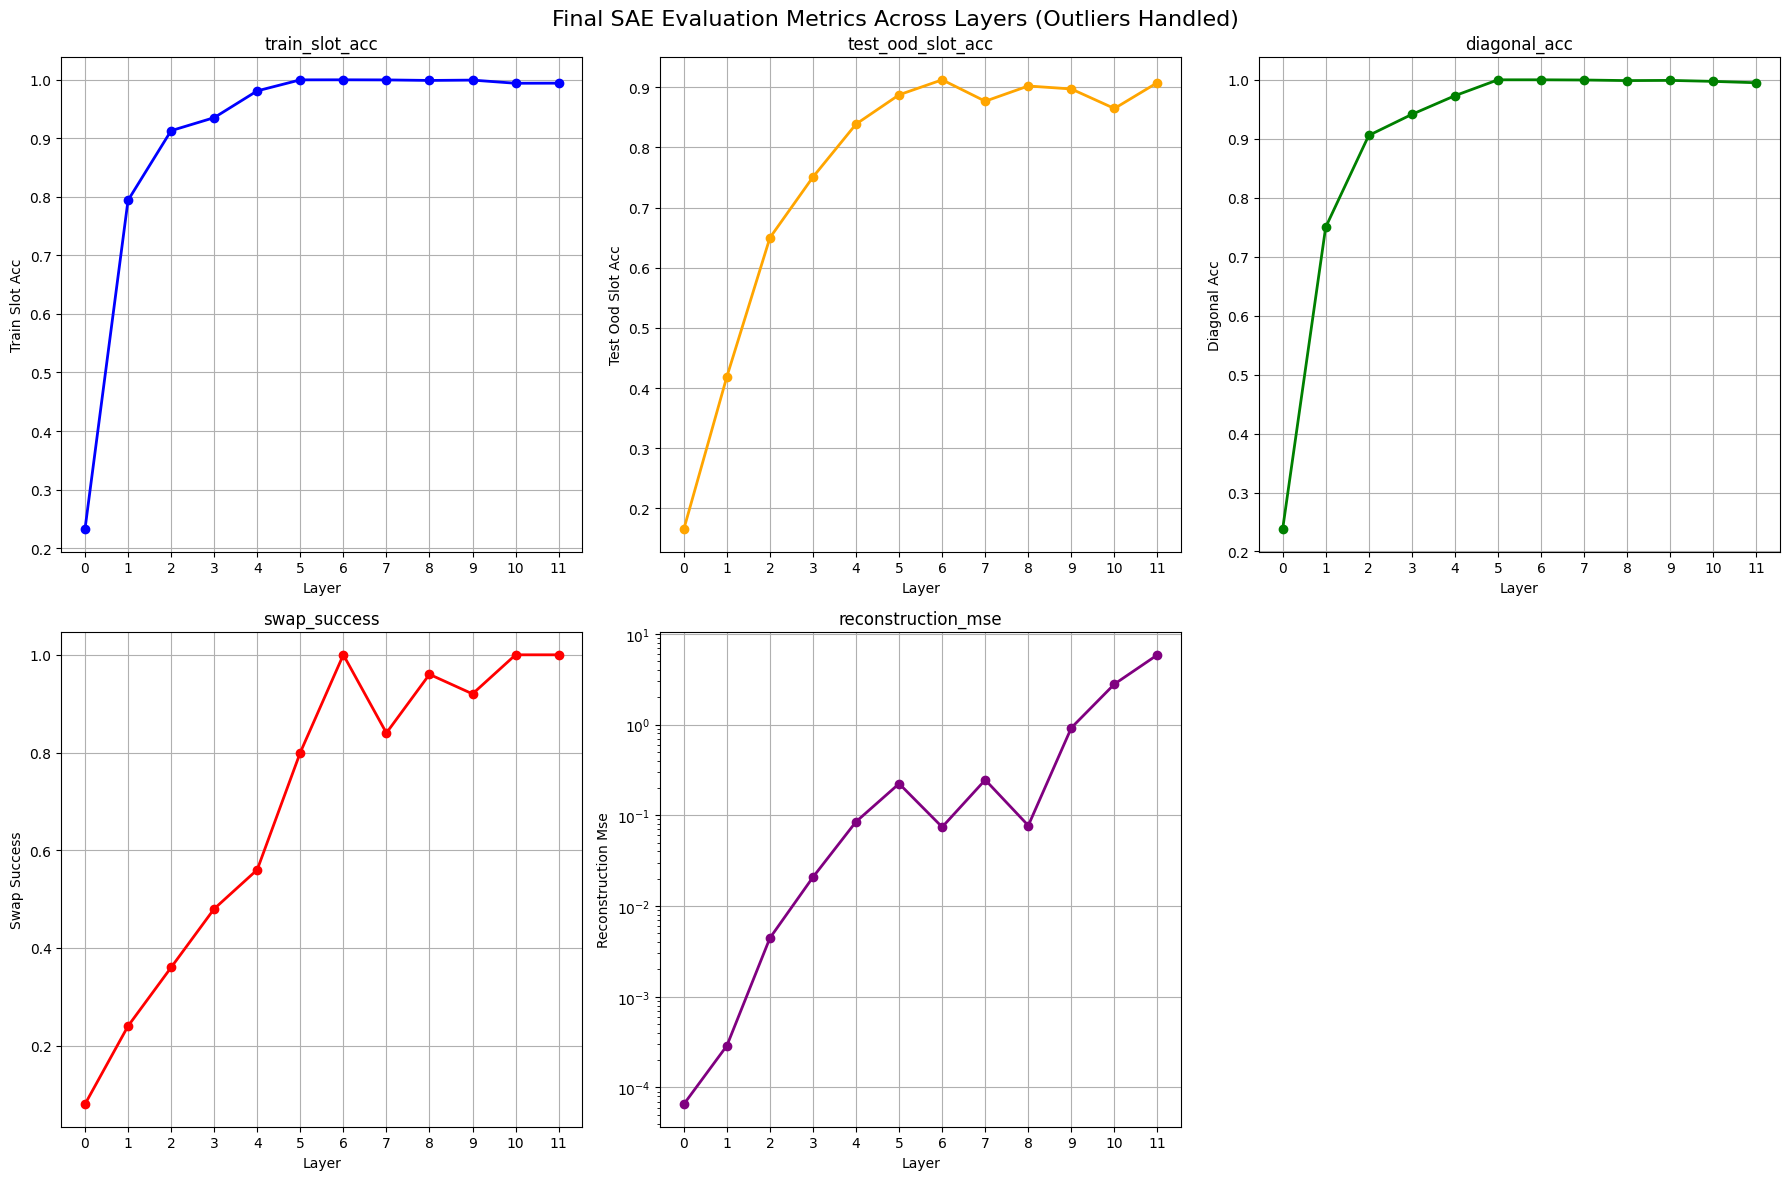

Final results line plot with outlier handling displayed and saved.


In [4]:
# Plot final results from pipeline_summary.json
import json

# Load the summary
with open('/home/mlyang721/bio_data/results/sae_per_layer/pipeline_summary.json', 'r') as f:
    summary = json.load(f)

layer_results = summary['layer_results']
layers = [int(layer) for layer in layer_results.keys()]  # Convert to int for sorting
layers.sort()
layers_str = [str(l) for l in layers]
metrics = ['train_slot_acc', 'test_ood_slot_acc', 'diagonal_acc', 'swap_success', 'reconstruction_mse']

# Prepare data
data = {metric: [layer_results[str(layer)][metric] for layer in layers] for metric in metrics}

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Final SAE Evaluation Metrics Across Layers (Outliers Handled)', fontsize=16)
axes = axes.flatten()

colors = ['blue', 'orange', 'green', 'red', 'purple']

for i, metric in enumerate(metrics):
    ax = axes[i]
    ax.plot(layers, data[metric], marker='o', color=colors[i], linewidth=2, markersize=6)
    ax.set_title(metric)
    ax.set_xlabel('Layer')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.grid(True)
    ax.set_xticks(layers)
    ax.set_xticklabels(layers_str)
    
    # Handle outliers for reconstruction_mse
    if metric == 'reconstruction_mse':
        ax.set_yscale('log')

# Hide the last subplot if not used
if len(metrics) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.savefig('final_evaluation_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print("Final results line plot with outlier handling displayed and saved.")

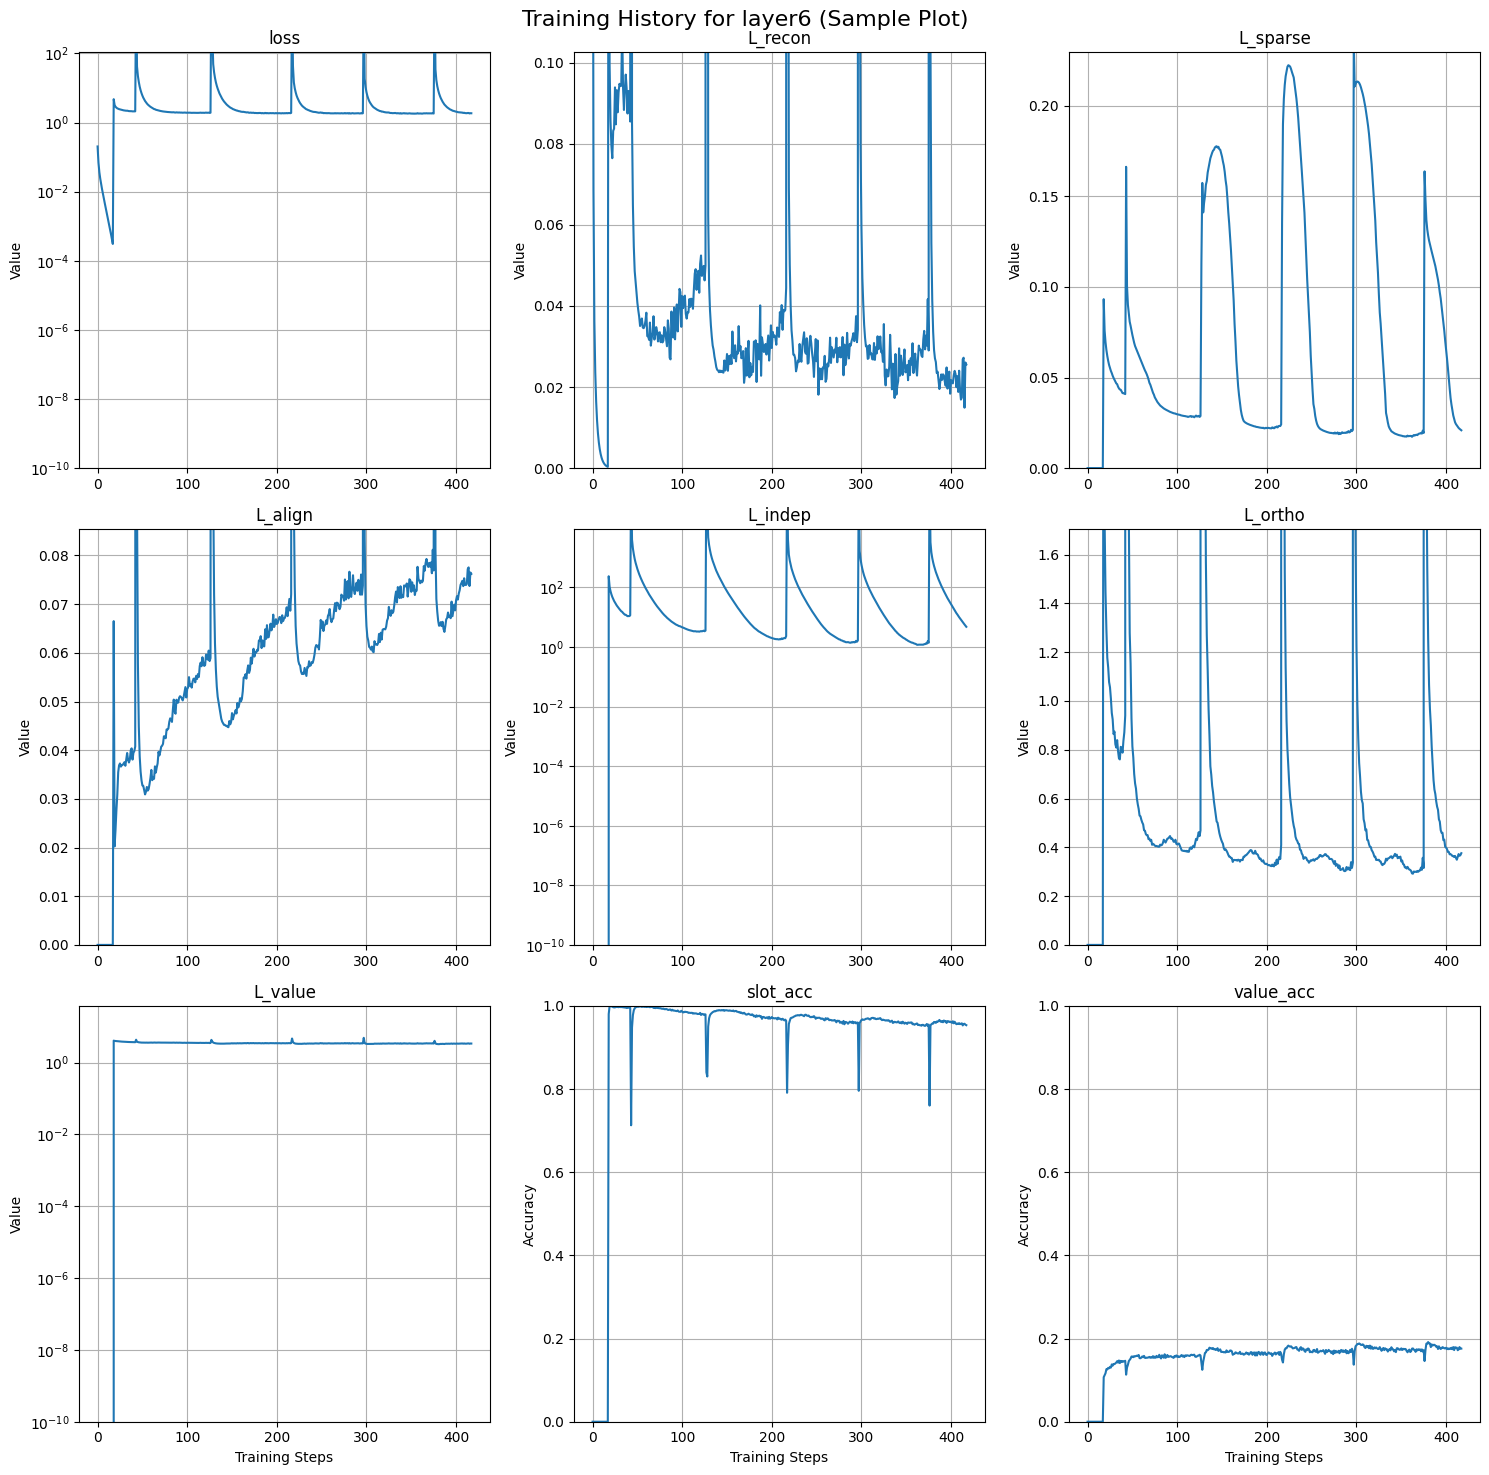

Sample plot for layer6 displayed and saved.


In [5]:
# Sample plot: Layer 6 Training History
layer = 'layer6'
data = load_layer_data(layer)

# Extract metrics
steps = list(range(len(data)))
metrics = {
    'loss': [entry['loss'] for entry in data],
    'L_recon': [entry['L_recon'] for entry in data],
    'L_sparse': [entry['L_sparse'] for entry in data],
    'L_align': [entry['L_align'] for entry in data],
    'L_indep': [entry['L_indep'] for entry in data],
    'L_ortho': [entry['L_ortho'] for entry in data],
    'L_value': [entry['L_value'] for entry in data],
    'slot_acc': [entry['slot_acc'] for entry in data],
    'value_acc': [entry['value_acc'] for entry in data]
}

# Create 3x3 subplot
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle(f'Training History for {layer} (Sample Plot)', fontsize=16)

# Flatten axes for easy iteration
axes = axes.flatten()

for i, (metric_name, values) in enumerate(metrics.items()):
    ax = axes[i]
    ax.plot(steps, values, label=metric_name)
    ax.set_title(metric_name)
    ax.grid(True)
    if i >= 6:  # Bottom row
        ax.set_xlabel('Training Steps')
    if metric_name in ['slot_acc', 'value_acc']:
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel('Value')
        # Handle outliers
        if metric_name in ['L_indep', 'L_value', 'loss']:
            ax.set_yscale('log')
            # Clip to 95th percentile
            import numpy as np
            percentile_95 = np.percentile([v for v in values if v > 0], 95)
            ax.set_ylim(bottom=1e-10, top=percentile_95 * 10)
        else:
            percentile_95 = np.percentile(values, 95)
            ax.set_ylim(0, percentile_95 * 1.1)

plt.tight_layout()
plt.savefig('layer6_training_history.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Sample plot for {layer} displayed and saved.")

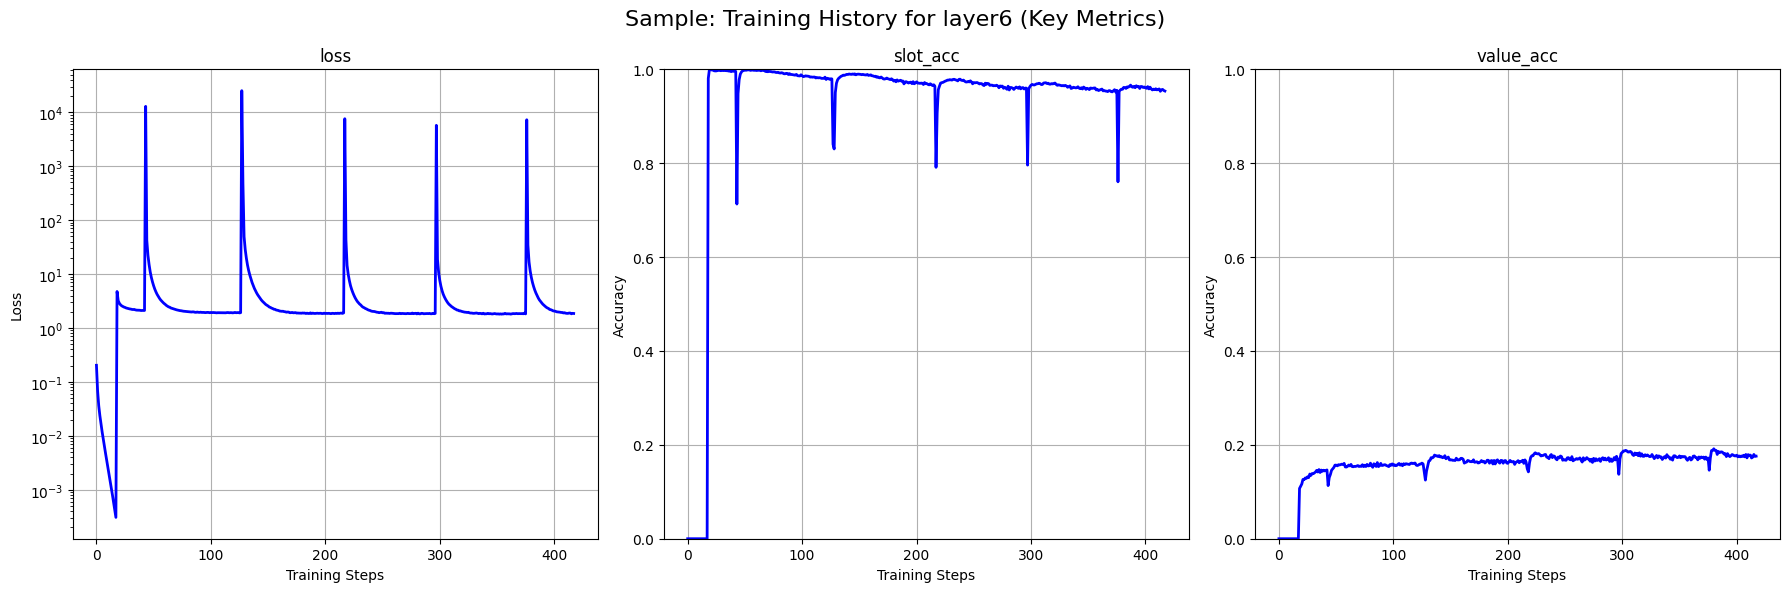

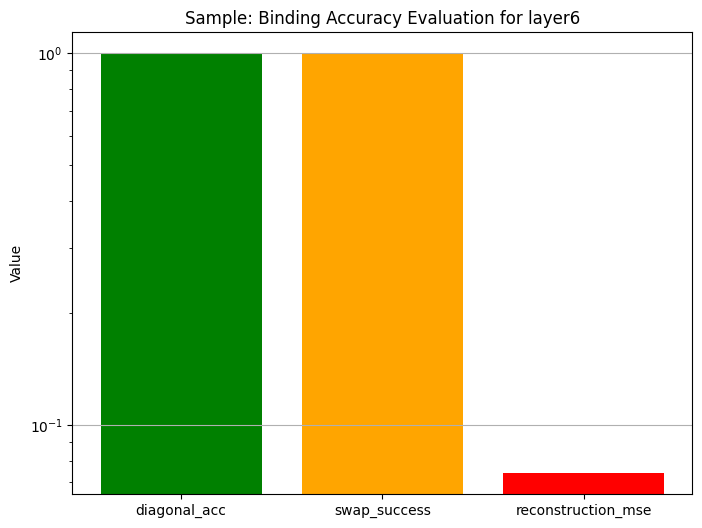

Sample plots for layer 6 displayed.


In [6]:
# Sample plot: Layer 6 training history and binding accuracy
import json
import matplotlib.pyplot as plt
import numpy as np

# Load layer 6 data
layer = 'layer6'
data = load_layer_data(layer)

# Extract metrics
steps = list(range(len(data)))
metrics = {
    'loss': [entry['loss'] for entry in data],
    'slot_acc': [entry['slot_acc'] for entry in data],
    'value_acc': [entry['value_acc'] for entry in data]
}

# Plot training history for layer 6
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle(f'Sample: Training History for {layer} (Key Metrics)', fontsize=16)

for i, (metric_name, values) in enumerate(metrics.items()):
    ax = axes[i]
    ax.plot(steps, values, color='blue', linewidth=2)
    ax.set_title(metric_name)
    ax.set_xlabel('Training Steps')
    ax.grid(True)
    if metric_name in ['slot_acc', 'value_acc']:
        ax.set_ylabel('Accuracy')
        ax.set_ylim(0, 1)
    else:
        ax.set_ylabel('Loss')
        ax.set_yscale('log')

plt.tight_layout()
plt.show()

# Load final results and plot binding accuracy (diagonal_acc) for layer 6
with open('/home/mlyang721/bio_data/results/sae_per_layer/pipeline_summary.json', 'r') as f:
    summary = json.load(f)

layer_results = summary['layer_results']
layer6_result = layer_results['6']

# Plot binding accuracy evaluation for layer 6
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
metrics_to_plot = ['diagonal_acc', 'swap_success', 'reconstruction_mse']
values = [layer6_result[m] for m in metrics_to_plot]
ax.bar(metrics_to_plot, values, color=['green', 'orange', 'red'])
ax.set_title(f'Sample: Binding Accuracy Evaluation for {layer}')
ax.set_ylabel('Value')
ax.set_yscale('log')  # Since reconstruction_mse is small
ax.grid(True, axis='y')
plt.show()

print("Sample plots for layer 6 displayed.")